In [ ]:
!pip install --upgrade yfinance --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install optuna --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.7 MB/s eta 0:00:00


## Step 1: Install & Import Required Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime
import matplotlib.dates as mdates

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

import cvxpy as cp

from sklearn.metrics import r2_score



# Set plotting style
sns.set(style='whitegrid')

## Step 2: Define Tickers and Download Historical Data

In [ ]:
# Define tickers and time period
tickers = [
    "XOM", "CVX", "SHEL", "TTFNF", "TTE", "COP", "WMB", "EOG", "LNG", "OKE",
    "PSX", "MPC", "HES", "FANG", "TRGP", "VLO", "IMO", "TPL", "CQP", "EXE",
    "DTM", "SUN", "NFG", "DCCPF", "GZPZF", "CHRD", "LB", "DLKGF", "GPOR",
    "TRRVF", "NRP", "LEU", "SBR", "PNRG", "FGPRB", "PDER", "AMEN", "RSRV",
    "TRKX", "LCNTU", "VIRDY", "CNR", "EXEEL", "EXEEZ", "PZZPF", "TTYP"
]

start_date = '2010-01-01'
#end_date = datetime.today().strftime('%Y-%m-%d')
end_date = '2025-04-30'

# Download price data
def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    close = data['Close']
    #returns = close.pct_change().dropna()
    return close


Close = download_data(tickers, start_date, end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  46 of 46 completed


In [ ]:
print(Close.shape)
Close.head()

(3854, 46)


Ticker           AMEN  CHRD  CNR        COP       CQP        CVX  DCCPF  \
Date                                                                      
2010-01-04  96.592468   NaN  NaN  23.572035  4.674616  43.122486    NaN   
2010-01-05  96.592468   NaN  NaN  23.594437  4.851474  43.427929    NaN   
2010-01-06  96.592468   NaN  NaN  23.764809  4.983252  43.433365    NaN   
2010-01-07  96.592468   NaN  NaN  23.670666  5.239870  43.269737    NaN   
2010-01-08  96.592468   NaN  NaN  23.876873  5.063010  43.346100    NaN   

Ticker      DLKGF  DTM        EOG  ...  TRGP  TRKX  TRRVF        TTE  TTFNF  \
Date                               ...                                        
2010-01-04    NaN  NaN  36.268810  ...   NaN   NaN    NaN  26.807287    NaN   
2010-01-05    NaN  NaN  35.824402  ...   NaN   NaN    NaN  26.868330    NaN   
2010-01-06    NaN  NaN  35.943634  ...   NaN   NaN    NaN  26.860184    NaN   
2010-01-07    NaN  NaN  35.607609  ...   NaN   NaN    NaN  26.799149    NaN   
2010-01-08    NaN  NaN  35.788261  ...   NaN   NaN    NaN  26.961916    NaN   

Ticker          TTYP         VIRDY        VLO       WMB        XOM  
Date                                                                
2010-01-04  7.263493  41279.691406   9.982553  8.169250  38.923954  
2010-01-05  7.263493  42157.984375  10.239235  8.271322  39.075932  
2010-01-06  7.263493  42908.191406  10.495911  8.539722  39.413670  
2010-01-07  7.526936  44591.582031  10.574028  8.479238  39.289814  
2010-01-08  7.526936  45872.421875  10.428952  8.547284  39.132221  

[5 rows x 46 columns]

In [ ]:
Close.tail()

Ticker            AMEN       CHRD        CNR        COP        CQP  \
Date                                                                 
2025-04-23  485.970001  92.790001  73.779999  89.930000  58.309223   
2025-04-24  485.970001  94.750000  75.190002  91.800003  58.358505   
2025-04-25  495.000000  94.620003  74.120003  91.720001  58.644333   
2025-04-28  495.000000  94.910004  74.660004  92.930000  59.541248   
2025-04-29  495.000000  93.510002  74.910004  91.879997  59.324409   

Ticker             CVX  DCCPF  DLKGF        DTM         EOG  ...        TRGP  \
Date                                                         ...               
2025-04-23  136.679993  67.25  158.0  96.919998  111.570000  ...  171.382339   
2025-04-24  139.070007  67.25  158.0  98.910004  113.459999  ...  176.006226   
2025-04-25  138.729996  67.25  158.0  98.709999  113.070000  ...  176.622742   
2025-04-28  140.100006  67.25  170.0  98.739998  114.139999  ...  178.243591   
2025-04-29  139.300003  67.25  170.0  98.529999  112.930000  ...  177.110001   

Ticker       TRKX       TRRVF        TTE      TTFNF  TTYP  VIRDY         VLO  \
Date                                                                           
2025-04-23  375.0   98.000000  58.700001  58.099998  58.0   73.0  114.500000   
2025-04-24  375.0   98.000000  59.279999  58.910000  58.0   73.0  113.360001   
2025-04-25  375.0  105.000000  59.950001  60.549999  58.0   73.0  113.870003   
2025-04-28  375.0  104.650002  60.080002  60.849998  58.0   73.0  114.750000   
2025-04-29  375.0  104.650002  58.450001  58.119999  58.0   73.0  115.519997   

Ticker            WMB         XOM  
Date                               
2025-04-23  58.480000  107.370003  
2025-04-24  59.610001  108.629997  
2025-04-25  59.029999  108.570000  
2025-04-28  59.660000  108.629997  
2025-04-29  59.669998  108.360001  

[5 rows x 46 columns]

Before we proceed to the next step wchich is EDA, we would like to remove tickers without complete data.

In [ ]:
# Handle missing data
def clean_data(df, threshold=1.0):
    # Drop stocks with more than threshold% missing values
    df = df.dropna(axis=1, thresh=int(df.shape[0] * threshold))
    # Forward fill then backfill remaining missing values
    df = df.ffill().bfill()
    return df

Prices = clean_data(Close)

# Show summary
print("Downloaded data shape:", Prices.shape)
print("Remaining tickers after filtering:", Prices.columns.tolist())

Downloaded data shape: (3854, 24)
Remaining tickers after filtering: ['AMEN', 'COP', 'CQP', 'CVX', 'EOG', 'HES', 'IMO', 'LEU', 'LNG', 'NFG', 'NRP', 'OKE', 'PDER', 'PNRG', 'RSRV', 'SBR', 'SHEL', 'TPL', 'TTE', 'TTYP', 'VIRDY', 'VLO', 'WMB', 'XOM']


## Step 3: Calculate Daily Returns

In [ ]:
returns = Prices.pct_change().dropna()
returns.tail()

Ticker          AMEN       COP       CQP       CVX       EOG       HES  \
Date                                                                     
2025-04-23  0.000000  0.001894  0.004585 -0.004516  0.002246 -0.002685   
2025-04-24  0.000000  0.020794  0.000845  0.017486  0.016940  0.018073   
2025-04-25  0.018581 -0.000871  0.004898 -0.002445 -0.003437 -0.000302   
2025-04-28  0.000000  0.013192  0.015294  0.009875  0.009463  0.011334   
2025-04-29  0.000000 -0.011299 -0.003642 -0.005710 -0.010601 -0.009713   

Ticker           IMO       LEU       LNG       NFG  ...  RSRV       SBR  \
Date                                                ...                   
2025-04-23 -0.011917  0.031274 -0.007441 -0.005754  ...   0.0 -0.001657   
2025-04-24  0.014592  0.022001  0.018326  0.002701  ...   0.0  0.010260   
2025-04-25  0.011447  0.011782  0.003918 -0.000770  ...   0.0  0.002539   
2025-04-28  0.007690  0.011645  0.018955  0.005777  ...   0.0  0.001192   
2025-04-29 -0.000432  0.008384  0.000968 -0.008934  ...   0.0  0.001488   

Ticker          SHEL       TPL       TTE  TTYP  VIRDY       VLO       WMB  \
Date                                                                        
2025-04-23 -0.010127  0.015468 -0.011618   0.0    0.0  0.018140  0.004811   
2025-04-24  0.008371  0.003825  0.009881   0.0    0.0 -0.009956  0.019323   
2025-04-25  0.012452 -0.000868  0.011302   0.0    0.0  0.004499 -0.009730   
2025-04-28  0.002429  0.011801  0.002168   0.0    0.0  0.007728  0.010673   
2025-04-29 -0.007725 -0.014877 -0.027131   0.0    0.0  0.006710  0.000168   

Ticker           XOM  
Date                  
2025-04-23 -0.008587  
2025-04-24  0.011735  
2025-04-25 -0.000552  
2025-04-28  0.000553  
2025-04-29 -0.002485  

[5 rows x 24 columns]

In [ ]:
returns_monthly = Prices.resample('M').last().pct_change().dropna()
returns_monthly.tail()

<ipython-input-9-8a89f16028e2>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_monthly = Prices.resample('M').last().pct_change().dropna()


Ticker          AMEN       COP       CQP       CVX       EOG       HES  \
Date                                                                     
2024-12-31 -0.022958 -0.084641 -0.088069 -0.105539 -0.080144 -0.093042   
2025-01-31  0.026000 -0.003428  0.155120  0.030033  0.033486  0.045260   
2025-02-28  0.095517  0.011379  0.118239  0.075001  0.009142  0.071280   
2025-03-31  0.032346  0.059203 -0.024664  0.054659  0.010241  0.076077   
2025-04-30 -0.131579 -0.125119 -0.088583 -0.167314 -0.111324 -0.170225   

Ticker           IMO       LEU       LNG       NFG  ...      RSRV       SBR  \
Date                                                ...                       
2024-12-31 -0.166667 -0.268022 -0.040802 -0.043347  ... -0.018000  0.001986   
2025-01-31  0.081818  0.235550  0.040862  0.154087  ...  0.092390  0.028256   
2025-02-28  0.018007  0.102430  0.024297  0.073825  ... -0.033898 -0.005394   
2025-03-31  0.066038 -0.314339  0.012426  0.059986  ...  0.011696  0.039673   
2025-04-30 -0.040100  0.140653  0.027787 -0.019447  ... -0.126590  0.002209   

Ticker          SHEL       TPL       TTE      TTYP     VIRDY       VLO  \
Date                                                                     
2024-12-31 -0.032283 -0.308122 -0.045625  0.008217  0.000000 -0.118565   
2025-01-31  0.051077  0.172891  0.064771 -0.042647  0.000000  0.093778   
2025-02-28  0.035454  0.100819  0.037911 -0.009217  0.387206 -0.017068   
2025-03-31  0.086273 -0.071062  0.088418  0.000000  0.082969  0.010250   
2025-04-30 -0.106032  0.004000 -0.096460 -0.100775  0.177419 -0.125312   

Ticker           WMB       XOM  
Date                            
2024-12-31 -0.067159 -0.088081  
2025-01-31  0.024205 -0.006879  
2025-02-28  0.049612  0.051444  
2025-03-31  0.036381  0.068266  
2025-04-30 -0.001506 -0.088876  

[5 rows x 24 columns]

## Step 4: Basic EDA

### 4.1 Summary Statistics

In [ ]:
# Summary statistics of returns
summary_stats = returns.describe().T[['mean', 'std', 'min', 'max']]
summary_stats['skew'] = returns.skew()
summary_stats['kurtosis'] = returns.kurtosis()
summary_stats.sort_values(by='mean', ascending=False).head(10)

mean       std       min        max       skew     kurtosis
Ticker                                                                 
VIRDY   0.016698  1.084562 -0.990000  67.253969  61.887782  3837.727375
LNG     0.001691  0.032146 -0.357657   0.686275   2.810020    65.226367
TPL     0.001657  0.026181 -0.248859   0.261400   0.328700    10.612077
AMEN    0.001446  0.045770 -0.327619   0.495727   1.547588    23.892269
LEU     0.001302  0.067393 -0.601589   1.438944   5.122503    94.501136
TTYP    0.001158  0.035833 -0.371428   0.605505   3.158808    72.602282
PNRG    0.001051  0.036116 -0.303874   0.579477   1.486782    28.505560
VLO     0.000937  0.024592 -0.192209   0.312026   0.429363    12.000675
CQP     0.000907  0.022055 -0.245628   0.160920  -0.838484    14.243642
OKE     0.000879  0.023554 -0.377553   0.333116  -0.886244    43.396523

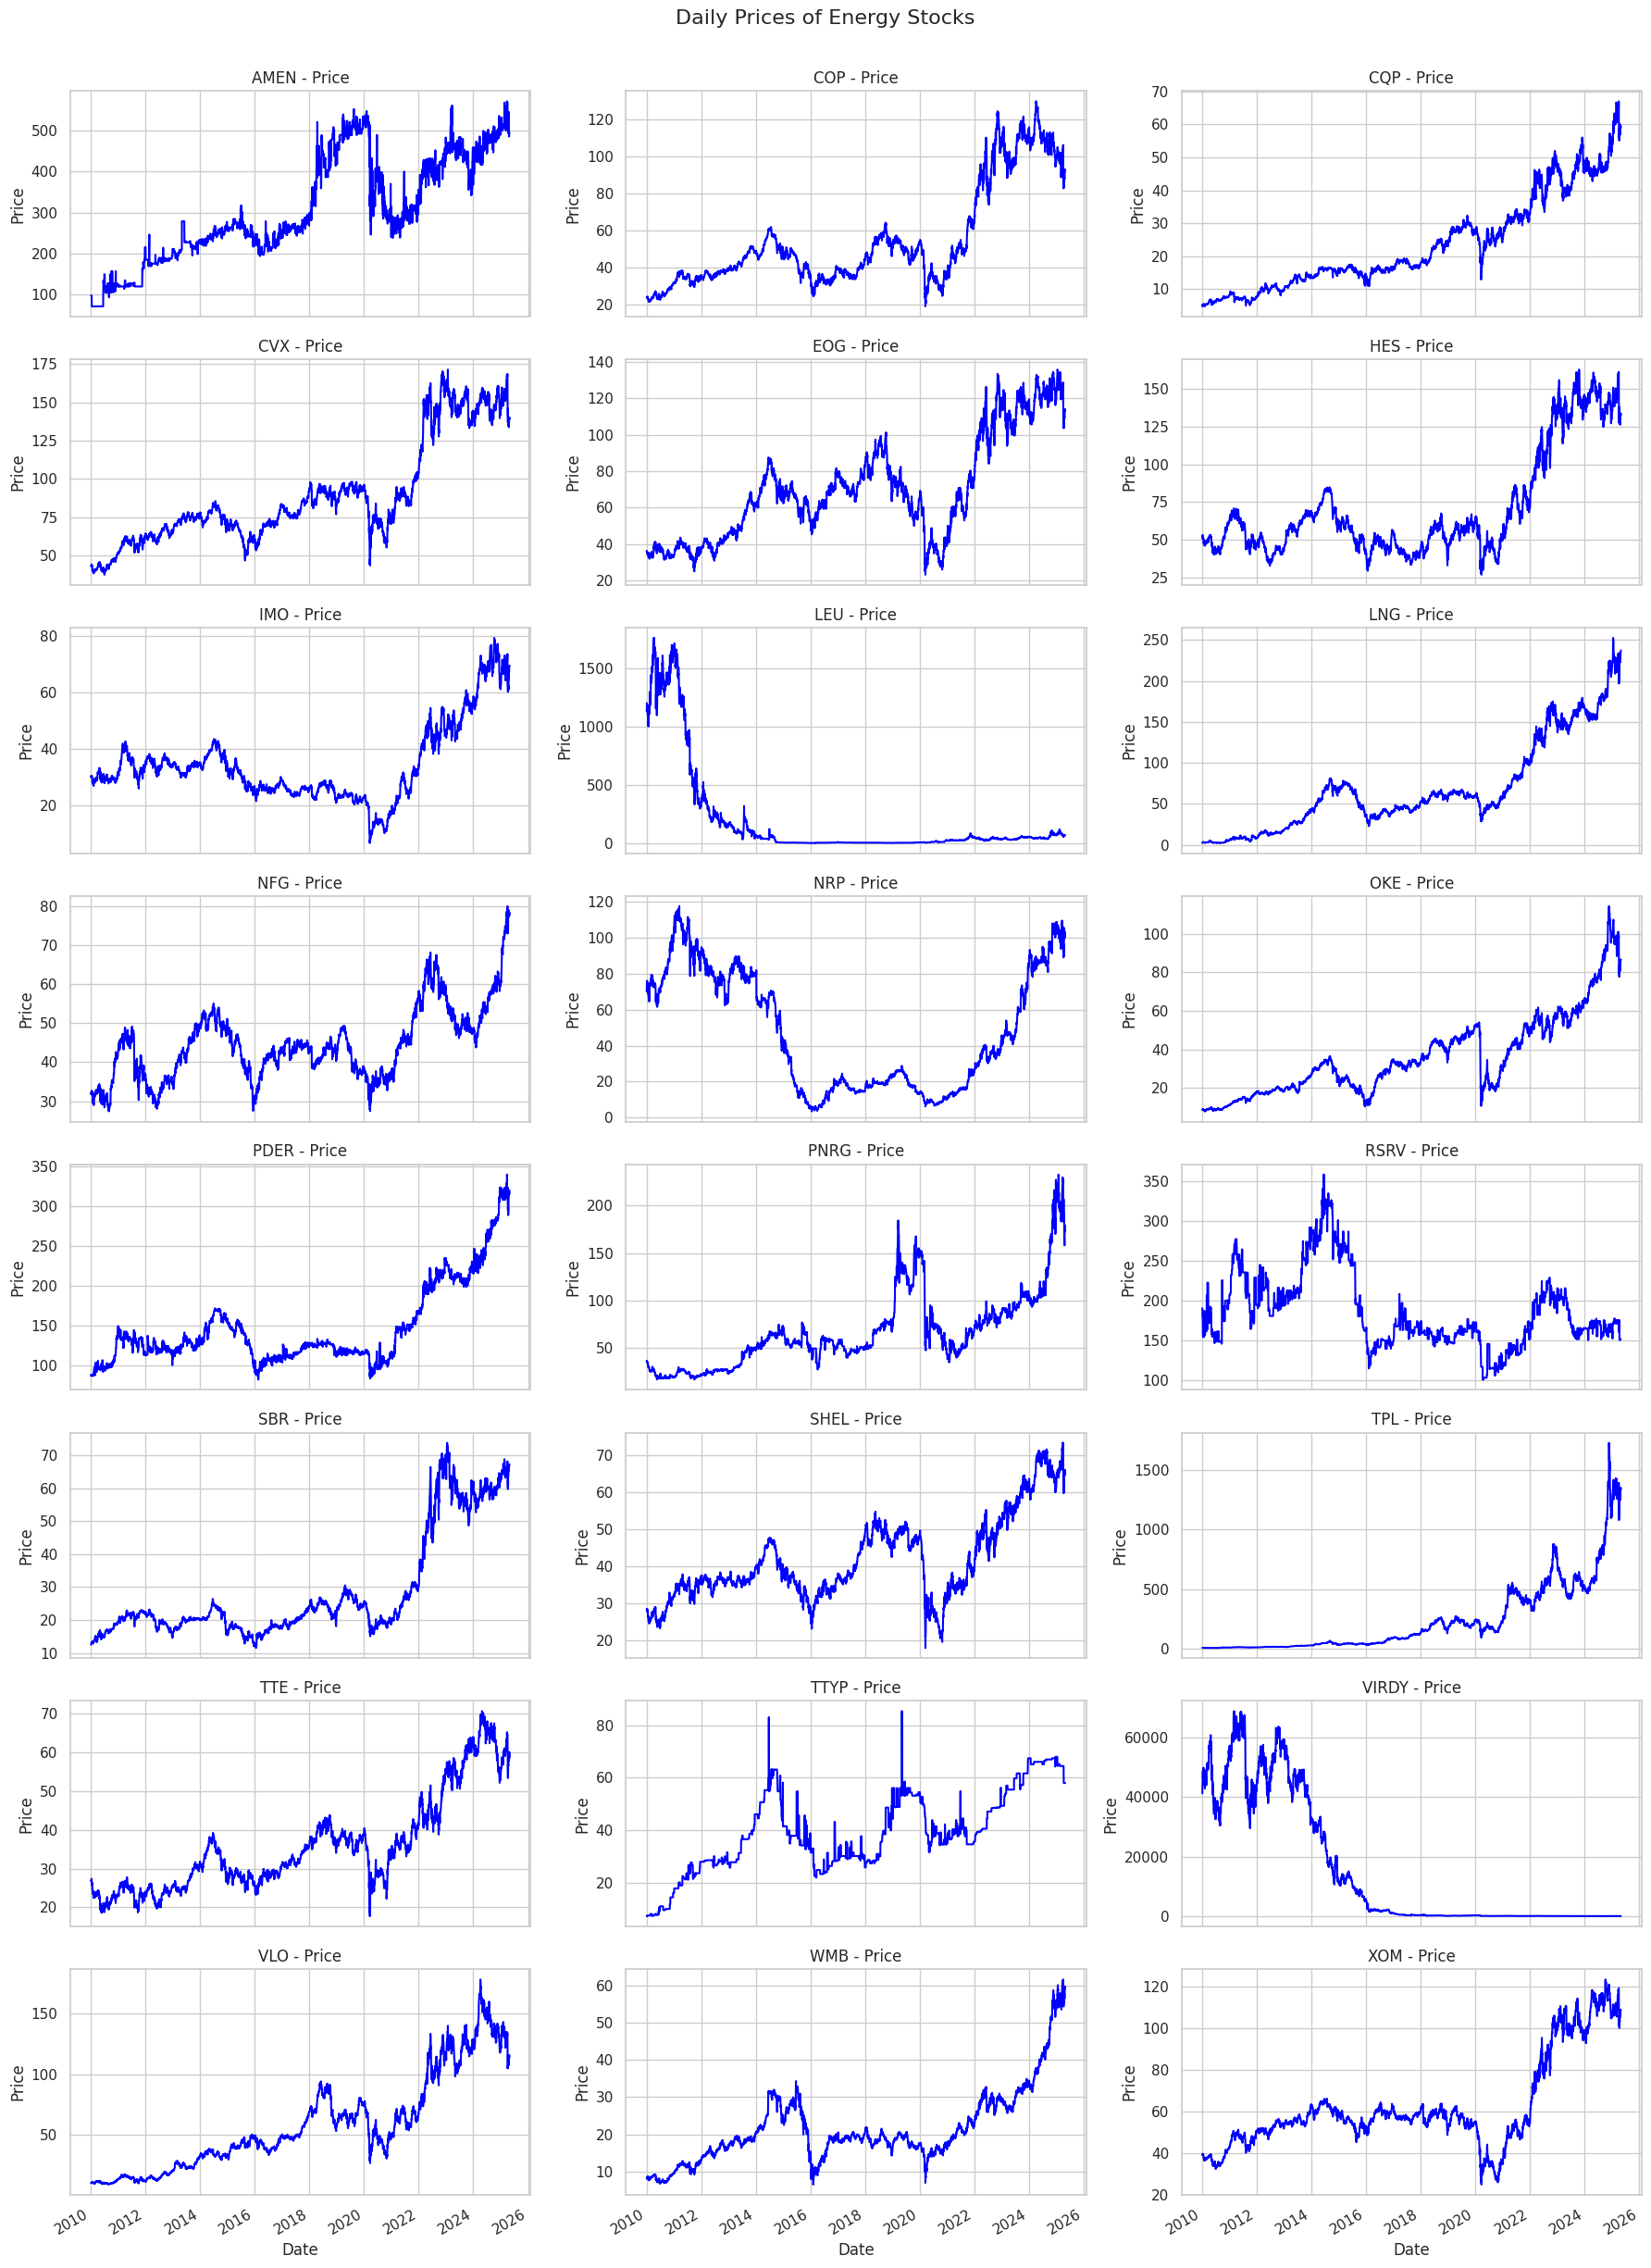

In [ ]:
tickers = Prices.columns
num_tickers = len(tickers)
cols = 3  # 3 columns in the subplot grid
rows = math.ceil(num_tickers / cols)

# Plot Prices
fig1, axes1 = plt.subplots(rows, cols, figsize=(18, rows * 3), sharex=True)
axes1 = axes1.flatten()

for i, ticker in enumerate(tickers):
    ax = axes1[i]
    Prices[ticker].plot(ax=ax, title=f"{ticker} - Price", color='blue')
    ax.set_ylabel("Price")
    ax.grid(True)

# Remove unused subplots
for j in range(i + 1, len(axes1)):
    fig1.delaxes(axes1[j])

plt.tight_layout()
plt.suptitle("Daily Prices of Energy Stocks", fontsize=16, y=1.02)
plt.show()

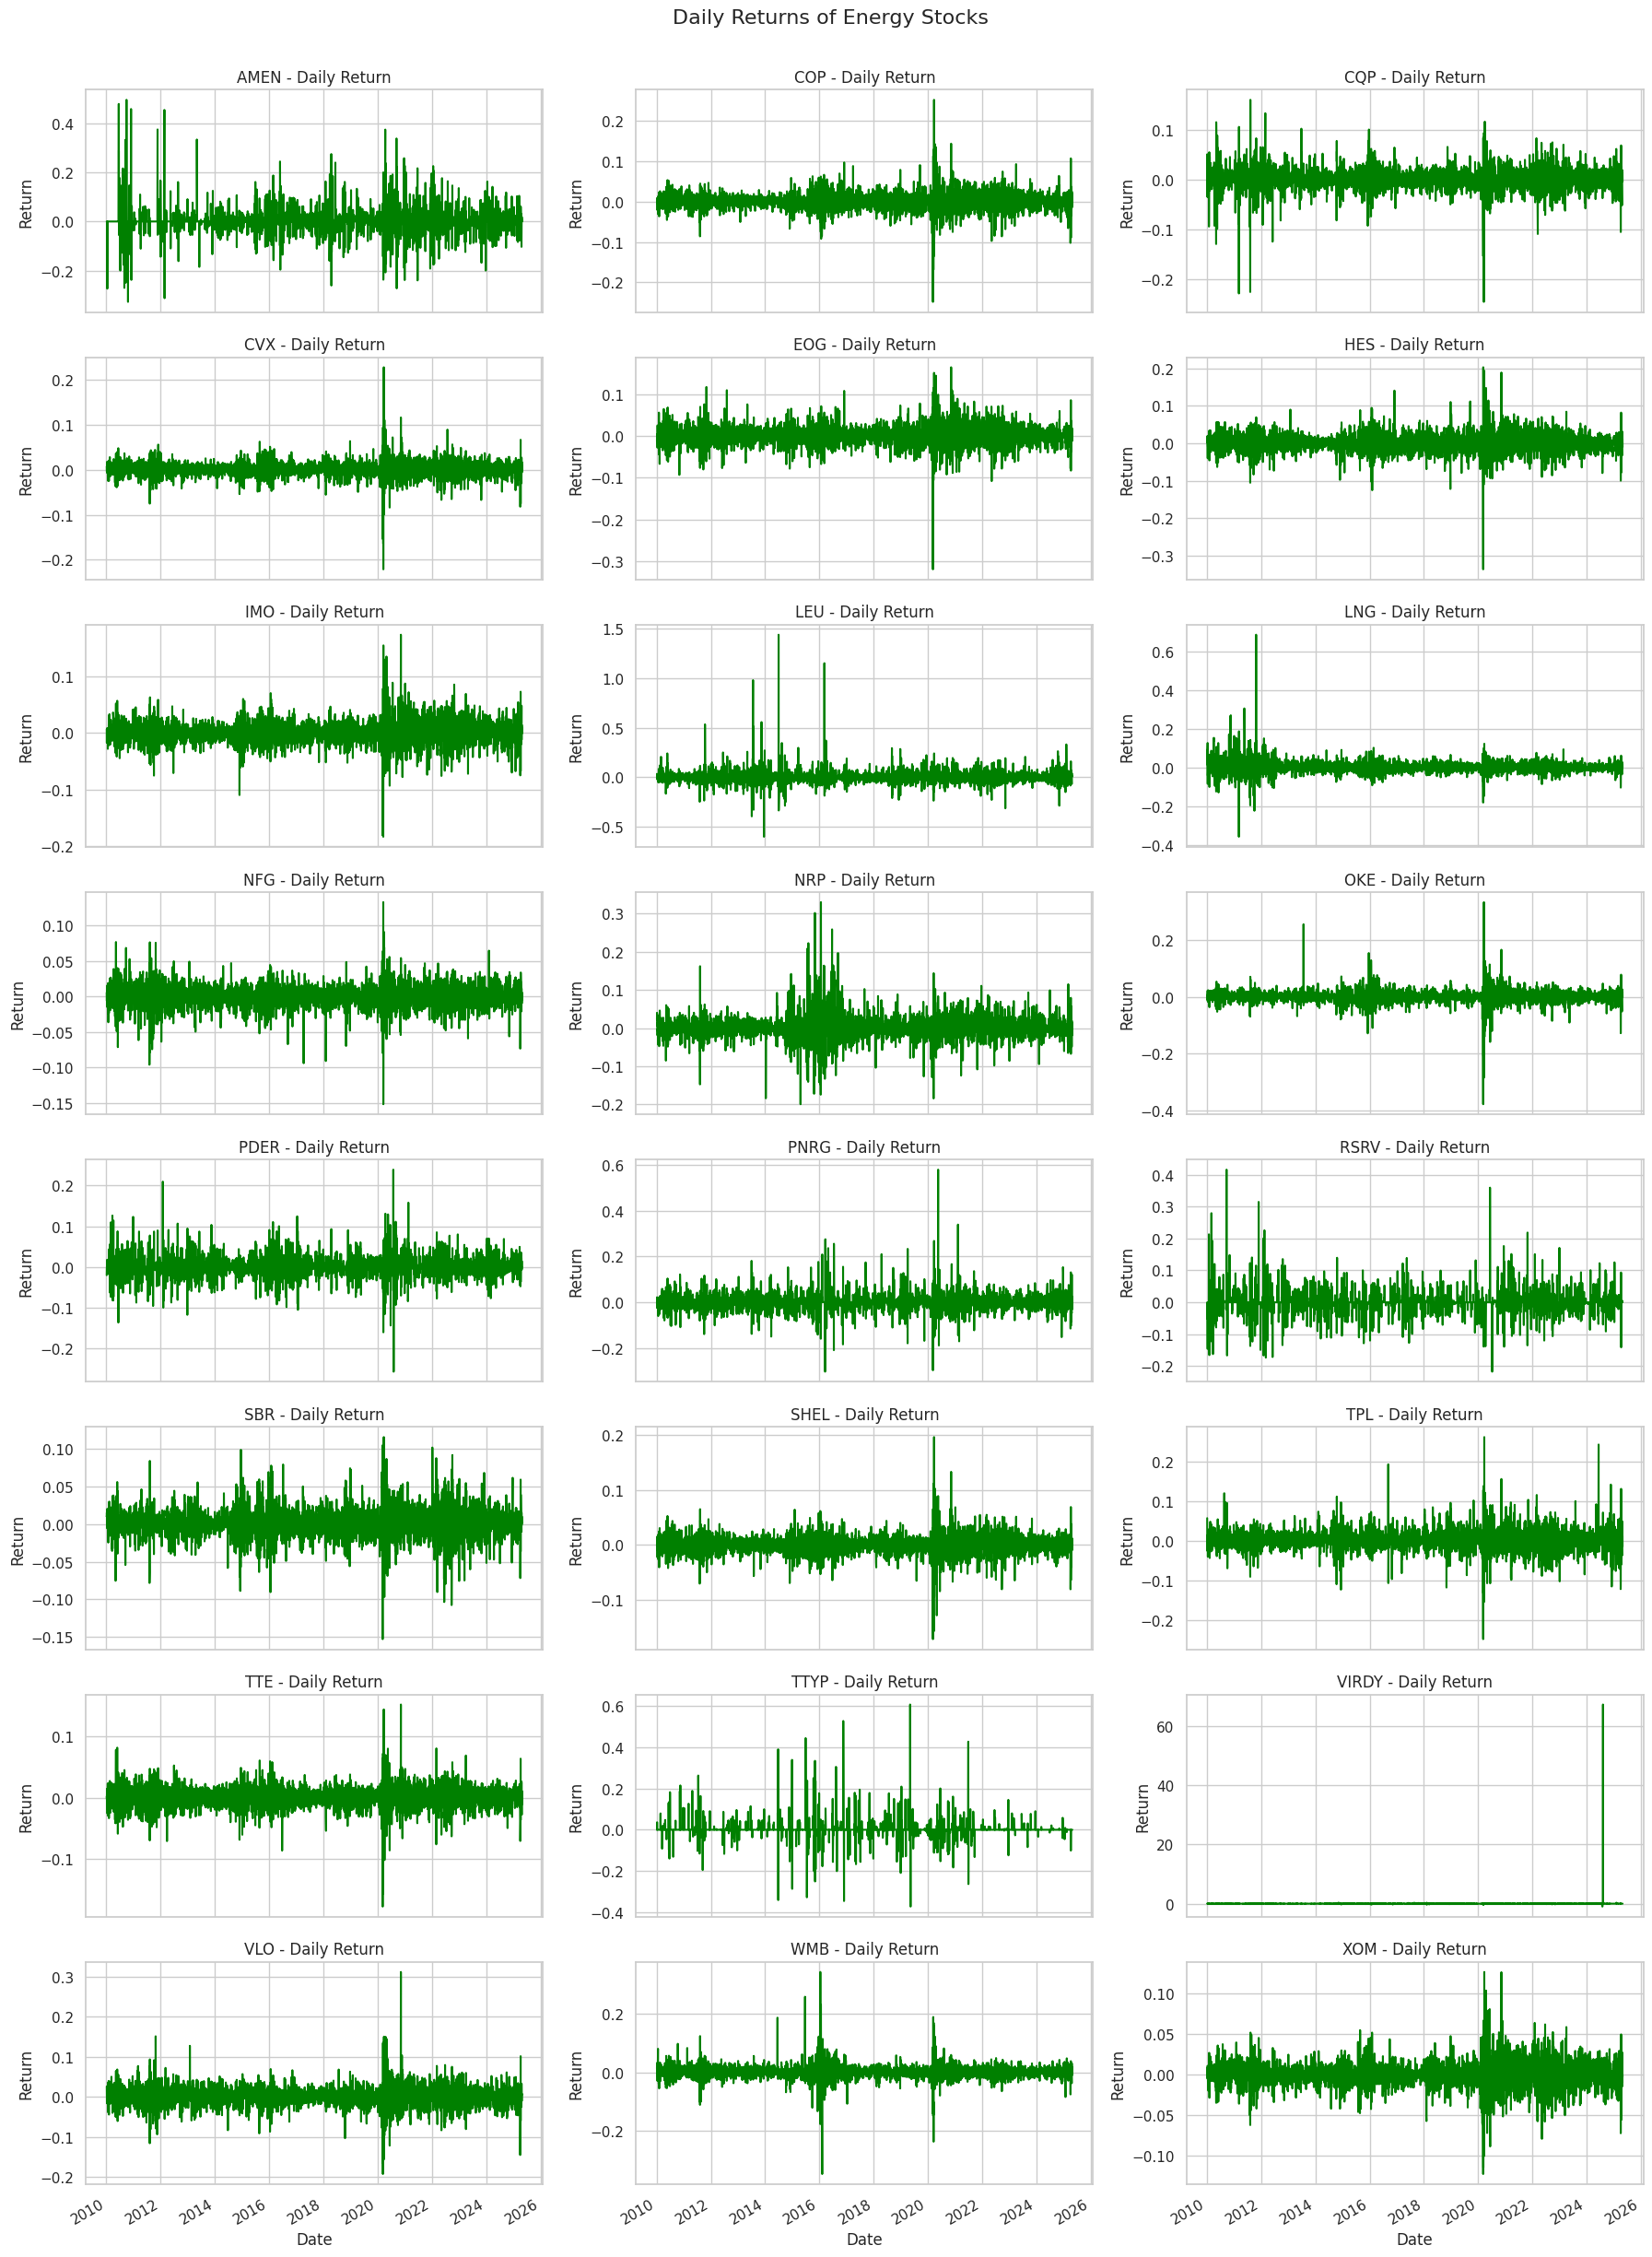

In [ ]:
# Plot Returns
fig2, axes2 = plt.subplots(rows, cols, figsize=(18, rows * 3), sharex=True)
axes2 = axes2.flatten()

for i, ticker in enumerate(tickers):
    ax = axes2[i]
    returns[ticker].plot(ax=ax, title=f"{ticker} - Daily Return", color='green')
    ax.set_ylabel("Return")
    ax.grid(True)

# Remove unused subplots
for j in range(i + 1, len(axes2)):
    fig2.delaxes(axes2[j])

plt.tight_layout()
plt.suptitle("Daily Returns of Energy Stocks", fontsize=16, y=1.02)
plt.show()


### 4.2 Correlation Heatmap

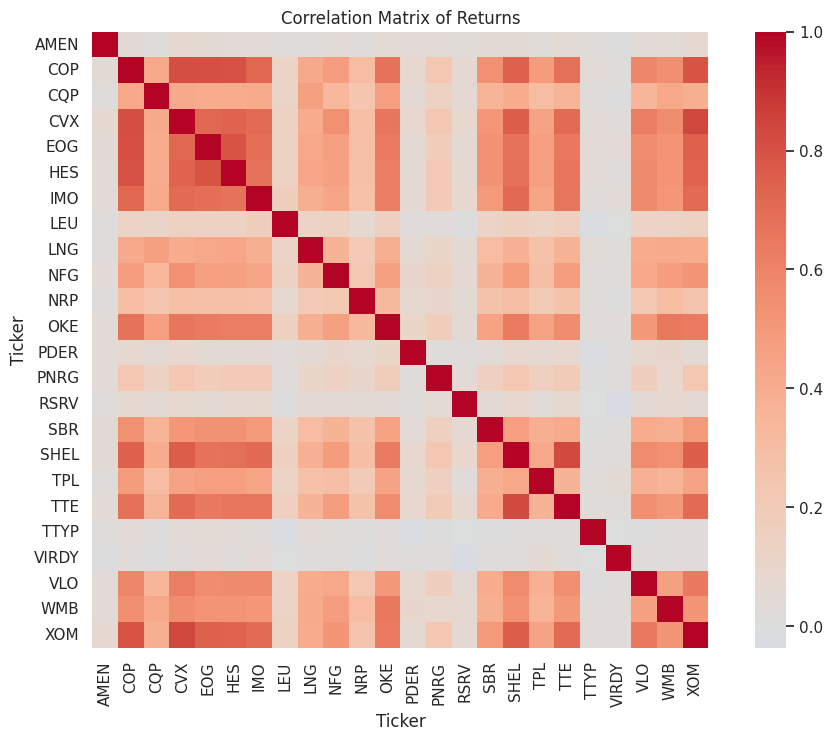

In [ ]:
plt.figure(figsize=(12, 8))
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Returns')
plt.show()


### 4.3 Volatility Analysis

In [ ]:
volatility= returns.std()
volatility

Ticker
AMEN     0.045770
COP      0.021409
CQP      0.022055
CVX      0.016965
EOG      0.023802
HES      0.025260
IMO      0.020583
LEU      0.067393
LNG      0.032146
NFG      0.015779
NRP      0.030815
OKE      0.023554
PDER     0.023344
PNRG     0.036116
RSRV     0.029687
SBR      0.019080
SHEL     0.017684
TPL      0.026181
TTE      0.017677
TTYP     0.035833
VIRDY    1.084562
VLO      0.024592
WMB      0.023688
XOM      0.015798
dtype: float64

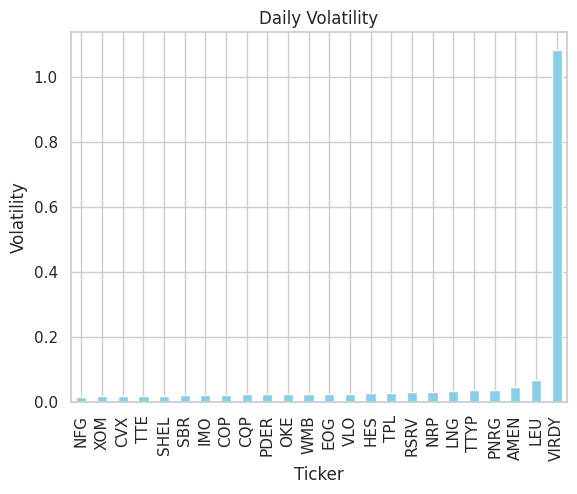

In [ ]:
volatility.sort_values().plot(kind='bar', color='skyblue', title="Daily Volatility")
plt.ylabel("Volatility")
plt.show()

<Axes: title={'center': 'Monthly Volatility'}, xlabel='Ticker'>

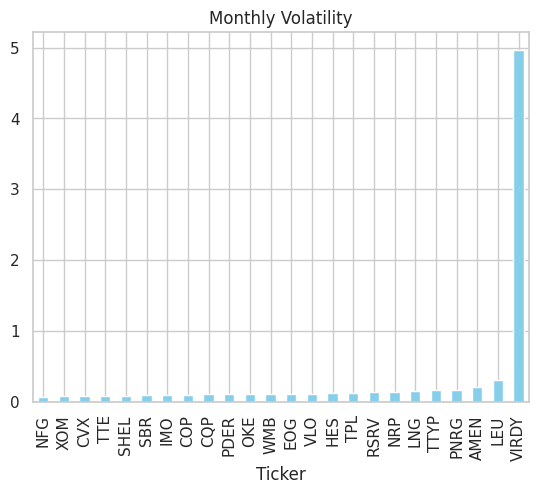

In [ ]:
volatility_month= returns.std()*np.sqrt(21)
volatility_month.sort_values().plot(kind='bar', color='skyblue', title="Monthly Volatility")

<Axes: title={'center': 'Yearly Volatility'}, xlabel='Ticker'>

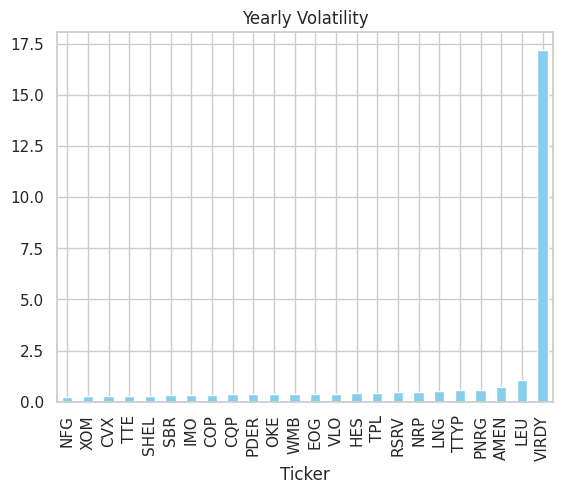

In [ ]:
volatility_annual= returns.std()*np.sqrt(252)
volatility_annual.sort_values().plot(kind='bar', color='skyblue', title="Yearly Volatility")

### 4.4 Cumulative Returns Plot

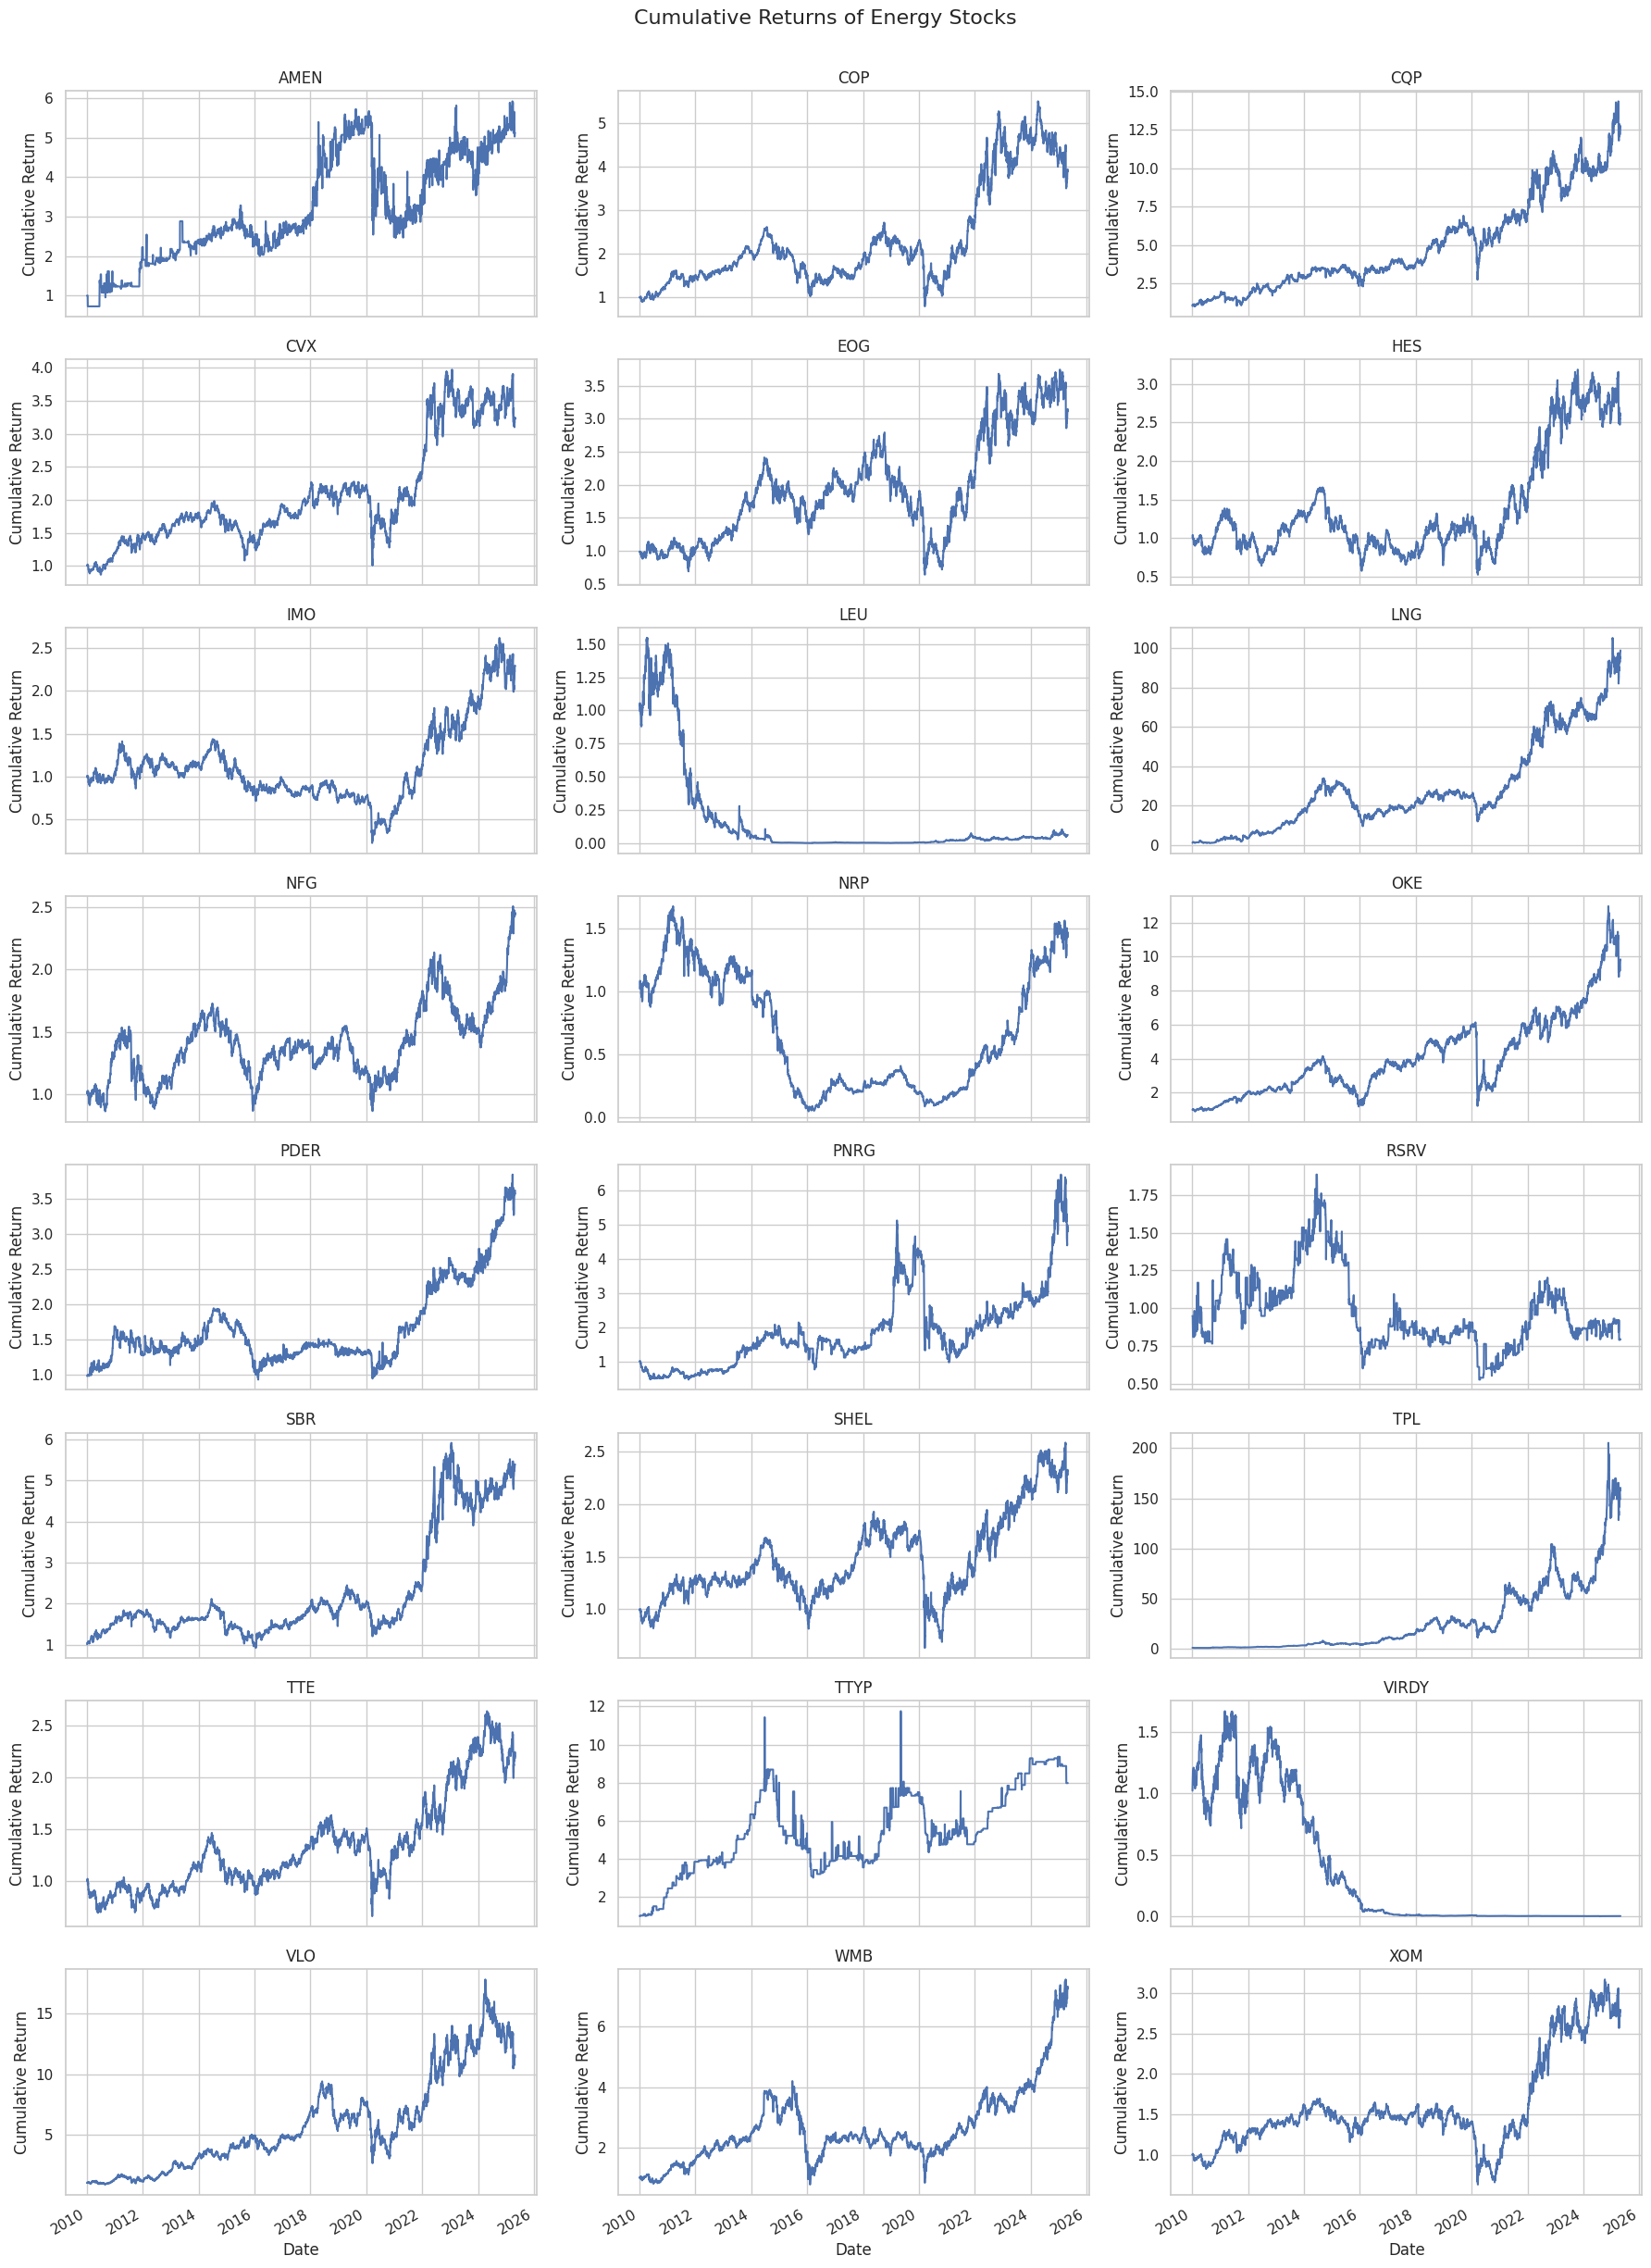

In [ ]:
cumulative_returns = (1 + returns).cumprod()

tickers = cumulative_returns.columns
num_tickers = len(tickers)

# Define subplot grid size (e.g., 3 columns)
cols = 3
rows = math.ceil(num_tickers / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3), sharex=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    ax = axes[i]
    cumulative_returns[ticker].plot(ax=ax, title=ticker)
    ax.set_ylabel("Cumulative Return")
    ax.grid(True)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle("Cumulative Returns of Energy Stocks", fontsize=16, y=1.02)
plt.show()


## 4.5 Plot of Average Returns vs Volatility

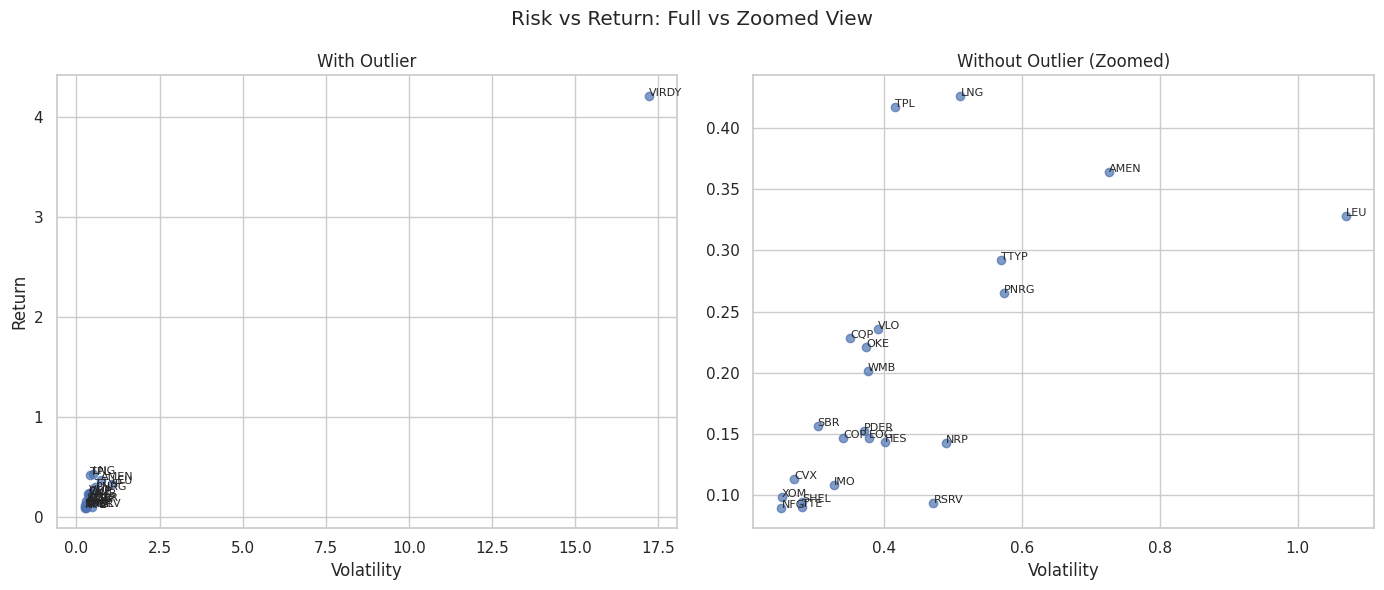

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot with outlier
avg_returns_all = returns.mean() * 252
volatility_all = returns.std() * np.sqrt(252)
axs[0].scatter(volatility_all, avg_returns_all, alpha=0.7)
for ticker in returns.columns:
    axs[0].text(volatility_all[ticker], avg_returns_all[ticker], ticker, fontsize=8)
axs[0].set_title('With Outlier')
axs[0].set_xlabel('Volatility')
axs[0].set_ylabel('Return')
axs[0].grid(True)

# Plot without outlier
returns_filtered = returns.drop(columns=["VIRDY"])
avg_returns_filt = returns_filtered.mean() * 252
volatility_filt = returns_filtered.std() * np.sqrt(252)
axs[1].scatter(volatility_filt, avg_returns_filt, alpha=0.7)
for ticker in returns_filtered.columns:
    axs[1].text(volatility_filt[ticker], avg_returns_filt[ticker], ticker, fontsize=8)
axs[1].set_title('Without Outlier (Zoomed)')
axs[1].set_xlabel('Volatility')
axs[1].grid(True)

plt.suptitle('Risk vs Return: Full vs Zoomed View')
plt.tight_layout()
plt.show()


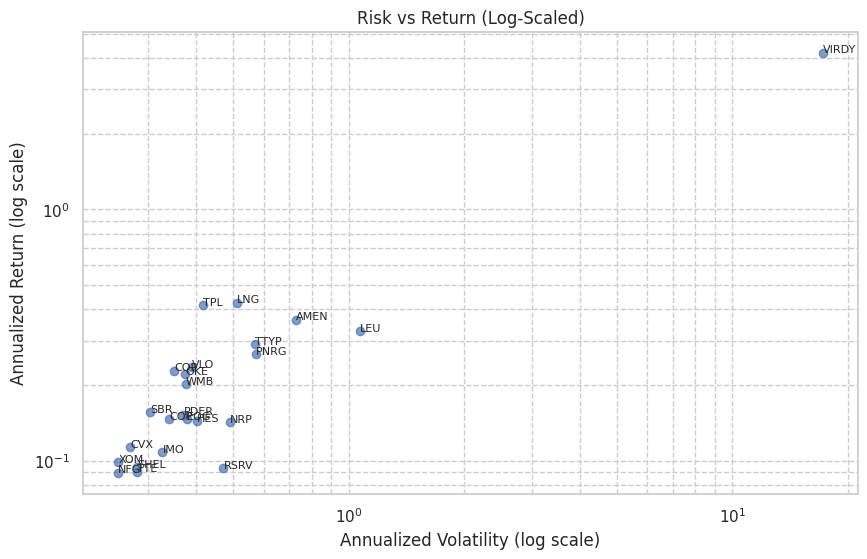

In [ ]:
avg_returns = returns.mean() * 252
volatility = returns.std() * np.sqrt(252)

plt.figure(figsize=(10, 6))
plt.scatter(volatility, avg_returns, alpha=0.7)
for ticker in returns.columns:
    plt.text(volatility[ticker], avg_returns[ticker], ticker, fontsize=8)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Annualized Volatility (log scale)')
plt.ylabel('Annualized Return (log scale)')
plt.title('Risk vs Return (Log-Scaled)')
plt.grid(True, which="both", ls="--")
plt.show()


<Axes: title={'center': 'Yearly Return'}, xlabel='Ticker'>

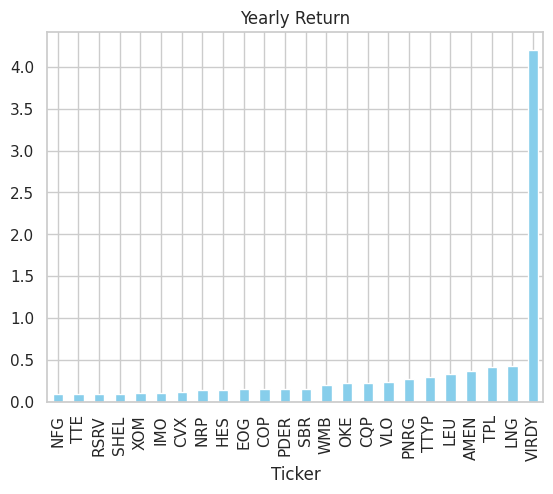

In [ ]:
avg_returns.sort_values().plot(kind='bar', color='skyblue', title="Yearly Return")

## **Analysis of the Distressed Market Regime**

### **Prices and The Distressed Period**

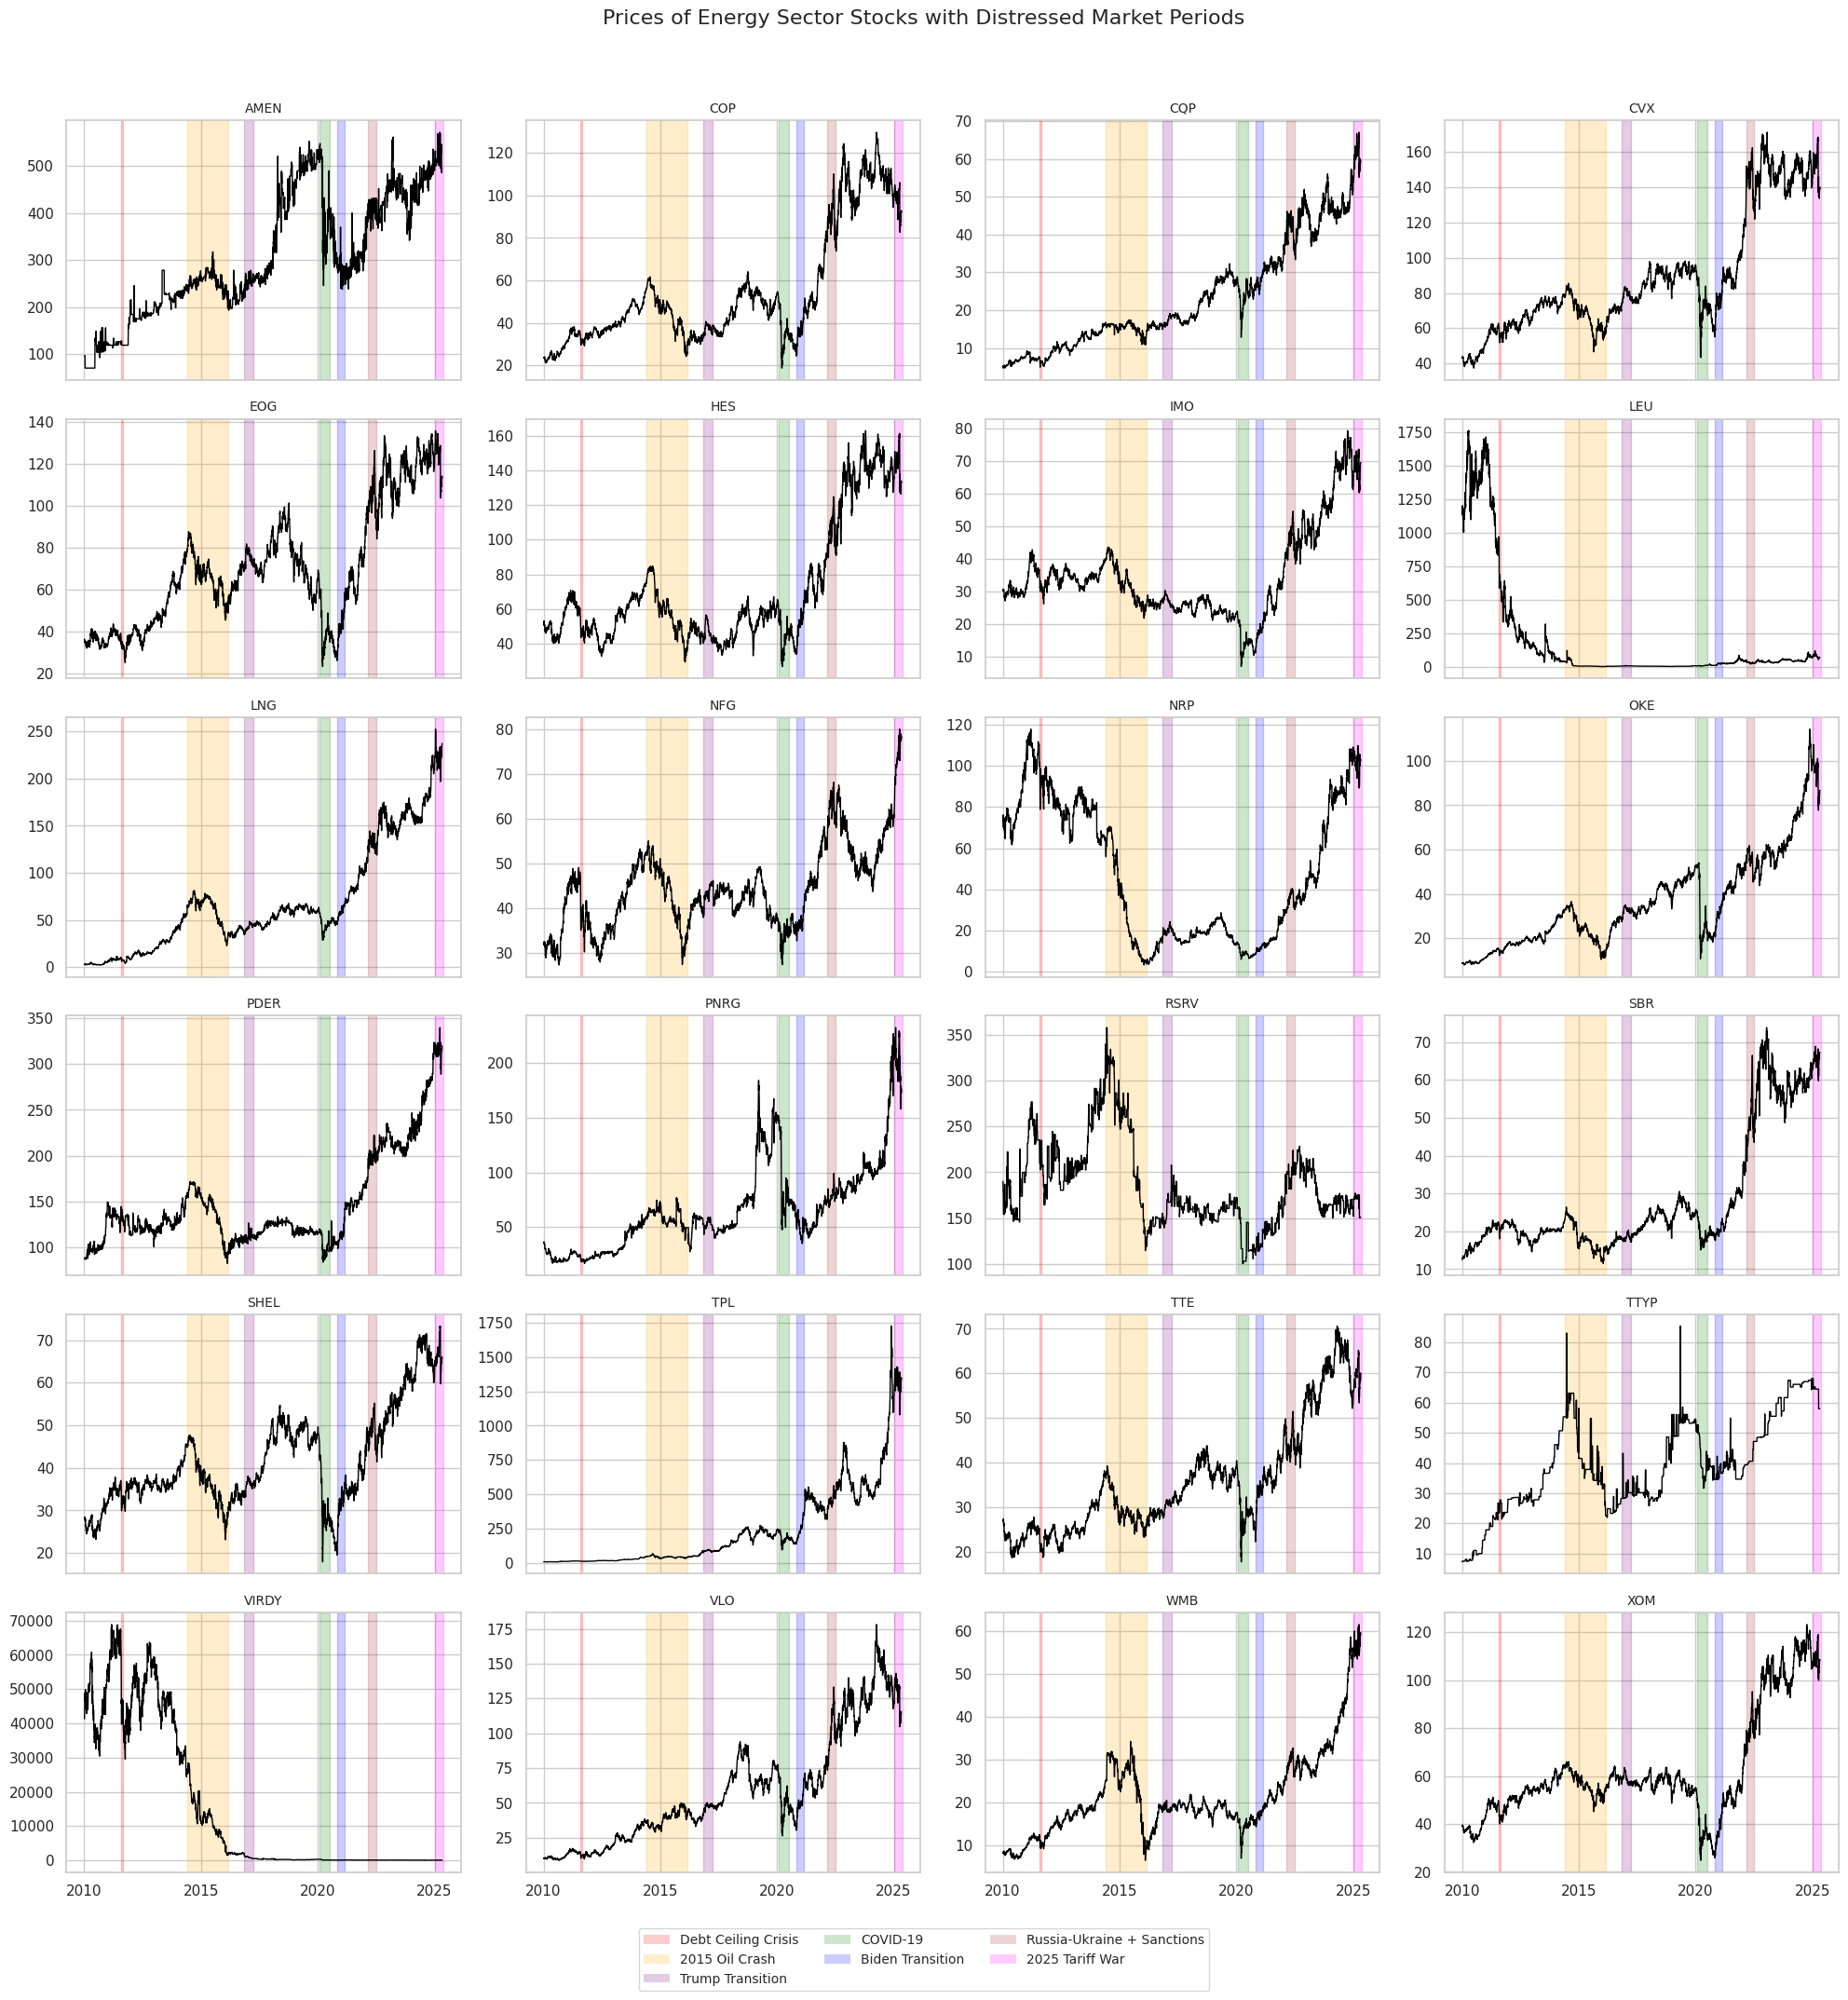

In [ ]:
# Define unique colors for each distressed period
distress_colors = [
    "red",           # 2011 Debt Ceiling
    "orange",        # 2015 Oil Crash
    "purple",        # Trump Transition
    "green",         # COVID-19
    "blue",          # Biden Transition
    "brown",         # Russia-Ukraine
    "magenta"        # 2025 Tariff War
]

# Define distress periods
distressed_periods = [
    ("2011-08-01", "2011-08-31", "Debt Ceiling Crisis"),
    ("2014-06-01", "2016-02-29", "2015 Oil Crash"),
    ("2016-11-01", "2017-03-31", "Trump Transition"),
    ("2020-02-01", "2020-06-30", "COVID-19"),
    ("2020-11-01", "2021-02-28", "Biden Transition"),
    ("2022-03-01", "2022-06-30", "Russia-Ukraine + Sanctions"),
    ("2025-01-01", pd.Timestamp.today().strftime('%Y-%m-%d'), "2025 Tariff War"),
]

# Setup grid
n_rows, n_cols = 6, 4
total_plots = len(Prices.columns)
pages = int(np.ceil(total_plots / (n_rows * n_cols)))
tickers = Prices.columns.tolist()

# Create legend handles only once
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=color, edgecolor='none', alpha=0.2, label=label)
    for (_, _, label), color in zip(distressed_periods, distress_colors)
]

for page in range(pages):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 22), sharex=True)
    axes = axes.flatten()

    start_idx = page * n_rows * n_cols
    end_idx = min(start_idx + n_rows * n_cols, total_plots)

    for i, idx in enumerate(range(start_idx, end_idx)):
        ticker = tickers[idx]
        ax = axes[i]

        # Plot cumulative return
        ax.plot(Prices.index, Prices[ticker], color='black', linewidth=1)
        ax.set_title(ticker, fontsize=10)
        ax.grid(True)

        # Add shaded distressed periods
        for (start, end, label), color in zip(distressed_periods, distress_colors):
            ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=0.2)

        # Format x-axis
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add legend below all subplots
    fig.legend(handles=legend_handles, loc='lower center', ncol=3, fontsize=10, frameon=True, bbox_to_anchor=(0.5, 0.01))

    plt.suptitle("Prices of Energy Sector Stocks with Distressed Market Periods", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # Leave space at bottom for legend
    plt.show()

### **Cumulative Returns and The Distressed Period**

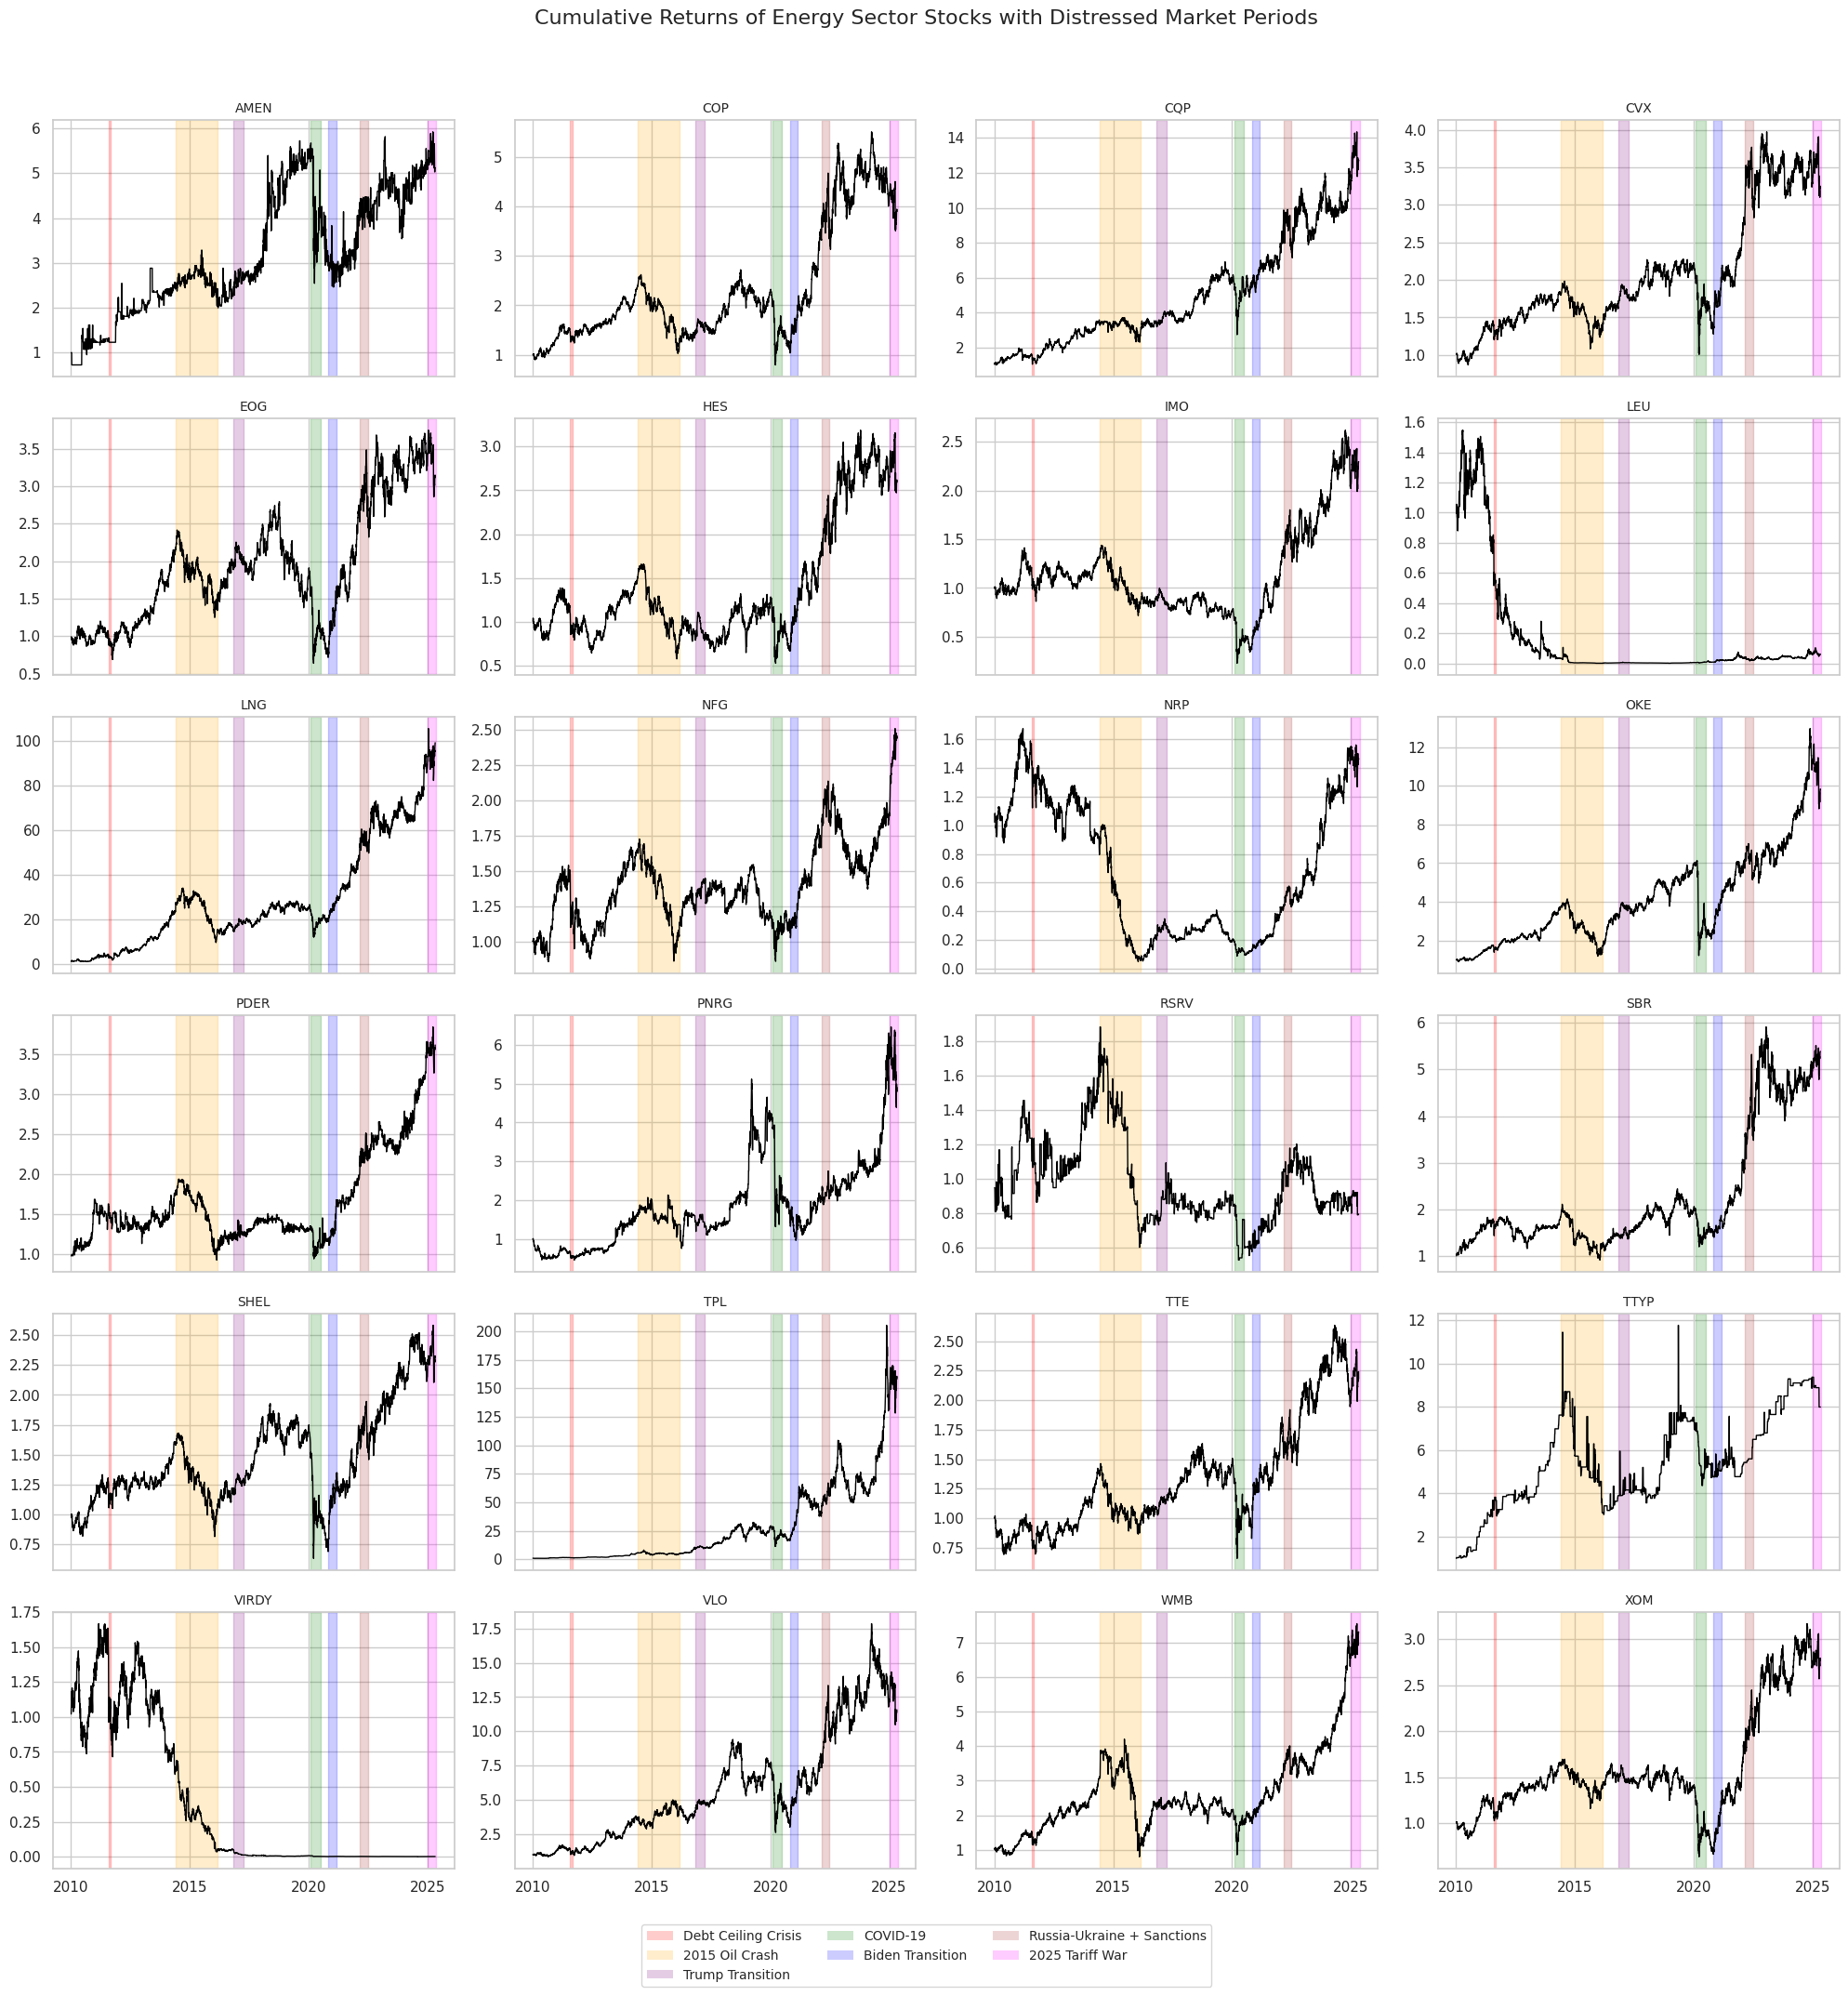

In [ ]:
# Define unique colors for each distressed period
distress_colors = [
    "red",           # 2011 Debt Ceiling
    "orange",        # 2015 Oil Crash
    "purple",        # Trump Transition
    "green",         # COVID-19
    "blue",          # Biden Transition
    "brown",         # Russia-Ukraine
    "magenta"        # 2025 Tariff War
]

# Define distress periods
distressed_periods = [
    ("2011-08-01", "2011-08-31", "Debt Ceiling Crisis"),
    ("2014-06-01", "2016-02-29", "2015 Oil Crash"),
    ("2016-11-01", "2017-03-31", "Trump Transition"),
    ("2020-02-01", "2020-06-30", "COVID-19"),
    ("2020-11-01", "2021-02-28", "Biden Transition"),
    ("2022-03-01", "2022-06-30", "Russia-Ukraine + Sanctions"),
    ("2025-01-01", pd.Timestamp.today().strftime('%Y-%m-%d'), "2025 Tariff War"),
]

# Setup grid
n_rows, n_cols = 6, 4
total_plots = len(cumulative_returns.columns)
pages = int(np.ceil(total_plots / (n_rows * n_cols)))
tickers = cumulative_returns.columns.tolist()

# Create legend handles only once
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=color, edgecolor='none', alpha=0.2, label=label)
    for (_, _, label), color in zip(distressed_periods, distress_colors)
]

for page in range(pages):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 22), sharex=True)
    axes = axes.flatten()

    start_idx = page * n_rows * n_cols
    end_idx = min(start_idx + n_rows * n_cols, total_plots)

    for i, idx in enumerate(range(start_idx, end_idx)):
        ticker = tickers[idx]
        ax = axes[i]

        # Plot cumulative return
        ax.plot(cumulative_returns.index, cumulative_returns[ticker], color='black', linewidth=1)
        ax.set_title(ticker, fontsize=10)
        ax.grid(True)

        # Add shaded distressed periods
        for (start, end, label), color in zip(distressed_periods, distress_colors):
            ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=0.2)

        # Format x-axis
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add legend below all subplots
    fig.legend(handles=legend_handles, loc='lower center', ncol=3, fontsize=10, frameon=True, bbox_to_anchor=(0.5, 0.01))

    plt.suptitle("Cumulative Returns of Energy Sector Stocks with Distressed Market Periods", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # Leave space at bottom for legend
    plt.show()


The chart labeled as “Cumulative Returns of Energy Sector Stocks with Distressed Market Periods” shows the performance of 24 energy sector stocks over the last almost 14 years in the beginning of 2025. Each subplot shows the accumulative gains of one stock, portraying how its price changes with time. Overlaid on the returns are seven different colour sections, each representing a major distressed market period: 2011 Debt Ceiling Crisis, 2015 Oil Crash, Trump then Biden transitions, COVID-19, Russia Ukraine – conflict with sanctions, and the current 2025 Tariff War. Each of these periods is differently shaded in different colors and is well-marked in the legend that is located under the chart.

From the analysis, we realize that most stocks registered extreme volatility during the distress periods. For example, the 2015 Oil Crash (orange) and COVID-19 (green) brought about strong declines or stagnation of many stock returns, indicating the fragility of the energy sector to global shocks. On the other hand, there are such periods with strong upward trends in many stocks, which are the post-COVID recovery and 2020–2021 political transitions, indicating the rebound effect or investor optimism. Interestingly enough, a select group of stocks such as LNG, TPL and XOM (stocks with outstanding long term growth where there are marked pickups even during a few distressed periods, indicating resilience, or genius, in testing times). All in all, the chart displays cyclicality of the energy sector and disparity in macroeconomic/geopolitical impact on individual firms.

In [ ]:
def calculate_technical_indicators(prices, window_sizes=[5, 10, 20, 50, 200]):
    """
    Calculate technical indicators for a list of stocks.
    prices: DataFrame with dates as index and stock tickers as columns
    window_sizes: list of window sizes for moving averages and other rolling calculations

    Returns: DataFrame with technical indicators
    """
    features = pd.DataFrame(index=prices.index)

    for ticker in prices.columns:
        close = prices[ticker]

        # 1. Price Returns (Target will be next period's return)
        features[f'{ticker}_return_1d'] = close.pct_change()
        features[f'{ticker}_return_5d'] = close.pct_change(5)
        features[f'{ticker}_return_20d'] = close.pct_change(20)

        # 2. Moving Averages
        for window in window_sizes:
            features[f'{ticker}_ma_{window}'] = close.rolling(window=window).mean()
            # Price to MA ratios
            features[f'{ticker}_close_to_ma_{window}_ratio'] = close / features[f'{ticker}_ma_{window}']

        # 3. Bollinger Bands (using close prices only)
        for window in [20, 50]:  # Common BB window sizes
            rolling_mean = close.rolling(window=window).mean()
            rolling_std = close.rolling(window=window).std()

            features[f'{ticker}_bb_upper_{window}'] = rolling_mean + (2 * rolling_std)
            features[f'{ticker}_bb_lower_{window}'] = rolling_mean - (2 * rolling_std)
            features[f'{ticker}_bb_width_{window}'] = (features[f'{ticker}_bb_upper_{window}'] -
                                                      features[f'{ticker}_bb_lower_{window}']) / rolling_mean

        # 4. Momentum Indicators
        # RSI (Relative Strength Index)
        for window in [14, 28]:  # Common RSI periods
            delta = close.diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)

            avg_gain = gain.rolling(window=window).mean()
            avg_loss = loss.rolling(window=window).mean()

            rs = avg_gain / avg_loss
            features[f'{ticker}_rsi_{window}'] = 100 - (100 / (1 + rs))

        # Rate of Change
        features[f'{ticker}_roc_10'] = close.pct_change(10)
        features[f'{ticker}_roc_20'] = close.pct_change(20)

        # 5. Volatility Measures
        features[f'{ticker}_volatility_10'] = close.pct_change().rolling(window=10).std()
        features[f'{ticker}_volatility_20'] = close.pct_change().rolling(window=20).std()

        # 6. Price Patterns
        # Donchian Channels
        for window in [20, 50]:
            features[f'{ticker}_donchian_upper_{window}'] = close.rolling(window=window).max()
            features[f'{ticker}_donchian_lower_{window}'] = close.rolling(window=window).min()
            features[f'{ticker}_donchian_middle_{window}'] = (
                features[f'{ticker}_donchian_upper_{window}'] +
                features[f'{ticker}_donchian_lower_{window}']
            ) / 2

        # 7. Moving Average Crossovers
        features[f'{ticker}_ma_cross_5_20'] = (
            features[f'{ticker}_ma_5'] > features[f'{ticker}_ma_20']
        ).astype(int)

        # 8. Price Extremes
        features[f'{ticker}_close_10d_high'] = close.rolling(window=10).max() / close - 1
        features[f'{ticker}_close_10d_low'] = close.rolling(window=10).min() / close - 1

    # Drop rows with NA values (from rolling calculations)
    features = features.dropna()

    return features

In [ ]:
features = calculate_technical_indicators(Prices)

<ipython-input-24-40ddccb427fa>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{ticker}_close_10d_high'] = close.rolling(window=10).max() / close - 1
<ipython-input-24-40ddccb427fa>:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{ticker}_close_10d_low'] = close.rolling(window=10).min() / close - 1
<ipython-input-24-40ddccb427fa>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

In [ ]:
features

AMEN_return_1d  AMEN_return_5d  AMEN_return_20d   AMEN_ma_5  \
Date                                                                      
2010-11-09        0.000000        0.147309        -0.228571  114.187195   
2010-11-10        0.049383        0.203966        -0.190476  118.466986   
2010-11-11        0.000000        0.203966        -0.190476  122.746777   
2010-11-12       -0.021176        0.027161        -0.207619  123.400635   
2010-11-15        0.000000        0.027161        -0.207619  124.054492   
...                    ...             ...              ...         ...   
2025-04-15        0.000000        0.057500         0.042987  514.270081   
2025-04-16        0.002364        0.071410         0.045453  521.335040   
2025-04-17        0.031132        0.104765        -0.024107  531.700000   
2025-04-21       -0.103385       -0.065777        -0.125000  524.800000   
2025-04-22       -0.008224       -0.080908        -0.139743  516.244000   

            AMEN_close_to_ma_5_ratio  AMEN_ma_10  AMEN_close_to_ma_10_ratio  \
Date                                                                          
2010-11-09                  1.054139  109.550747                   1.098752   
2010-11-10                  1.066232  111.690643                   1.130921   
2010-11-11                  1.029056  113.830538                   1.109661   
2010-11-12                  1.001927  115.702950                   1.068585   
2010-11-15                  0.996646  117.575361                   1.051567   
...                              ...         ...                        ...   
2025-04-15                  1.028156  518.035040                   1.020684   
2025-04-16                  1.016621  514.635040                   1.029856   
2025-04-17                  1.027835  516.785040                   1.057500   
2025-04-21                  0.933689  513.785040                   0.953706   
2025-04-22                  0.941357  512.382040                   0.948452   

            AMEN_ma_20  AMEN_close_to_ma_20_ratio  AMEN_ma_50  ...  \
Date                                                           ...   
2010-11-09  117.456475                   1.024798  121.474779  ...   
2010-11-10  115.970435                   1.089185  122.158357  ...   
2010-11-11  114.484394                   1.103323  122.841935  ...   
2010-11-12  112.864612                   1.095458  123.472015  ...   
2010-11-15  111.244830                   1.111408  123.864331  ...   
...                ...                        ...         ...  ...   
2025-04-15  536.698001                   0.985191  526.383853  ...   
2025-04-16  537.850140                   0.985405  526.672975  ...   
2025-04-17  537.175140                   1.017359  527.439466  ...   
2025-04-21  533.675140                   0.918162  527.075957  ...   
2025-04-22  529.728026                   0.917395  526.631848  ...   

            XOM_volatility_20  XOM_donchian_upper_20  XOM_donchian_lower_20  \
Date                                                                          
2010-11-09           0.009026              40.831921              37.365017   
2010-11-10           0.009041              41.120991              37.410976   
2010-11-11           0.009106              41.525658              37.410976   
2010-11-12           0.009753              41.525658              37.410976   
2010-11-15           0.009658              41.525658              37.410976   
...                       ...                    ...                    ...   
2025-04-15           0.028511             119.040001              99.930000   
2025-04-16           0.028347             119.040001              99.930000   
2025-04-17           0.029127             119.040001              99.930000   
2025-04-21           0.029232             119.040001              99.930000   
2025-04-22           0.030081             119.040001              99.930000   

            XOM_donchian_middle_20  XOM_donchian_upper_50  \
Date    

In [ ]:
#def create_target(prices, horizon=1):
 #   targets = pd.DataFrame(index=prices.index)
  #  for ticker in prices.columns:
   #     targets[f'{ticker}_target'] = prices[ticker].pct_change(horizon).shift(-horizon)
    #return targets.dropna()

#targets = create_target(Prices)

targets = np.log(Prices / Prices.shift(1))

In [ ]:
targets.head()

Ticker      AMEN       COP       CQP       CVX       EOG       HES       IMO  \
Date                                                                           
2010-01-04   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-05   0.0  0.000950  0.037136  0.007058 -0.012329  0.006156  0.006317   
2010-01-06   0.0  0.007195  0.026800  0.000125  0.003323  0.002671  0.004774   
2010-01-07   0.0 -0.003969  0.050214 -0.003774 -0.009393  0.018966 -0.017448   
2010-01-08   0.0  0.008674 -0.034335  0.001763  0.005061  0.013612  0.007877   

Ticker           LEU       LNG       NFG  ...      RSRV       SBR      SHEL  \
Date                                      ...                                 
2010-01-04       NaN       NaN       NaN  ...       NaN       NaN       NaN   
2010-01-05 -0.004831  0.015937  0.005709  ... -0.052186  0.010597  0.001122   
2010-01-06  0.033336  0.087011  0.002156  ...  0.000000  0.009775 -0.008204   
2010-01-07  0.025435  0.059772 -0.005892  ...  0.000000  0.015070 -0.004857   
2010-01-08 -0.018434  0.072400  0.006480  ...  0.000000  0.009072 -0.001462   

Ticker           TPL       TTE      TTYP     VIRDY       VLO       WMB  \
Date                                                                     
2010-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
2010-01-05  0.055097  0.002275  0.000000  0.021053  0.025388  0.012417   
2010-01-06 -0.025668 -0.000303  0.000000  0.017639  0.024759  0.031934   
2010-01-07 -0.008368 -0.002275  0.035627  0.038482  0.007415 -0.007108   
2010-01-08 -0.025534  0.006055  0.000000  0.028319 -0.013815  0.007993   

Ticker           XOM  
Date                  
2010-01-04       NaN  
2010-01-05  0.003897  
2010-01-06  0.008606  
2010-01-07 -0.003147  
2010-01-08 -0.004019  

[5 rows x 24 columns]

In [ ]:
def split_data(features, targets, test_start='2019-01-01'):
    """
    Split data into training and testing sets
    """
    X_train = features[features.index < test_start]
    X_test = features[features.index >= test_start]

    y_train = targets[targets.index < test_start]
    y_test = targets[targets.index >= test_start]

    # Ensure we have matching indices
    common_indices = X_train.index.intersection(y_train.index)
    X_train, y_train = X_train.loc[common_indices], y_train.loc[common_indices]

    common_indices = X_test.index.intersection(y_test.index)
    X_test, y_test = X_test.loc[common_indices], y_test.loc[common_indices]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_data(features, targets, test_start='2019-01-01')

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1395, 816)
(1076, 816)
(1395, 24)
(1076, 24)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_gbr(X_train, y_train):
    """
    Train a Gradient Boosting Regressor for multi-output regression
    """
    # Define the base regressor with hyperparameters
    gbr = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=10,
        random_state=42
    )

    # Wrap with MultiOutputRegressor to handle multiple outputs
    model = MultiOutputRegressor(gbr, n_jobs=-1)
    model.fit(X_train, y_train)

    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance
    """
    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return mae, mse, r2


In [ ]:
gbr = train_gbr(X_train, y_train)

In [ ]:
gbr_results = evaluate_model(gbr, X_test, y_test)

MAE: 0.0026
MSE: 0.0014
R2 Score: 0.8725


In [ ]:
# 5. Initialize and train model
model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=10,
        random_state=42
    ),
    n_jobs=-1
)

model.fit(X_train, y_train)

# 6. Evaluation function with NaN checks
def safe_evaluate_model(model, X, y, set_name="Train"):
    """Evaluation with additional data validation"""
    # Final NaN check
    if X.isna().any().any() or y.isna().any().any():
        raise ValueError(f"{set_name} set contains NaN values")

    preds = model.predict(X)

    # Calculate metrics for each stock
    mse = mean_squared_error(y, preds, multioutput='raw_values')
    r2 = r2_score(y, preds, multioutput='raw_values')

    print(f"\n{set_name} Set Performance:")
    for i, stock in enumerate(y.columns):
        print(f"{stock}: MSE={mse[i]:.6f}, R²={r2[i]:.4f}")

    return preds

# 7. Run evaluation
try:
    train_preds = safe_evaluate_model(model, X_train, y_train, "Train")
    test_preds = safe_evaluate_model(model, X_test, y_test, "Test")
except ValueError as e:
    print(f"Evaluation failed: {str(e)}")
    print("Debugging info:")
    print("X_train NA count:", X_train.isna().sum().sum())
    print("y_train NA count:", y_train.isna().sum().sum())
    print("X_test NA count:", X_test.isna().sum().sum())
    print("y_test NA count:", y_test.isna().sum().sum())


Train Set Performance:
AMEN: MSE=0.000000, R²=1.0000
COP: MSE=0.000000, R²=1.0000
CQP: MSE=0.000000, R²=1.0000
CVX: MSE=0.000000, R²=1.0000
EOG: MSE=0.000000, R²=1.0000
HES: MSE=0.000000, R²=1.0000
IMO: MSE=0.000000, R²=1.0000
LEU: MSE=0.000000, R²=0.9999
LNG: MSE=0.000000, R²=1.0000
NFG: MSE=0.000000, R²=1.0000
NRP: MSE=0.000000, R²=1.0000
OKE: MSE=0.000000, R²=1.0000
PDER: MSE=0.000000, R²=1.0000
PNRG: MSE=0.000000, R²=1.0000
RSRV: MSE=0.000000, R²=1.0000
SBR: MSE=0.000000, R²=1.0000
SHEL: MSE=0.000000, R²=1.0000
TPL: MSE=0.000000, R²=1.0000
TTE: MSE=0.000000, R²=1.0000
TTYP: MSE=0.000000, R²=1.0000
VIRDY: MSE=0.000000, R²=1.0000
VLO: MSE=0.000000, R²=1.0000
WMB: MSE=0.000000, R²=0.9999
XOM: MSE=0.000000, R²=1.0000

Test Set Performance:
AMEN: MSE=0.000064, R²=0.9772
COP: MSE=0.000082, R²=0.9037
CQP: MSE=0.000047, R²=0.9209
CVX: MSE=0.000082, R²=0.8481
EOG: MSE=0.000115, R²=0.8833
HES: MSE=0.000091, R²=0.9136
IMO: MSE=0.000090, R²=0.8836
LEU: MSE=0.000876, R²=0.7006
LNG: MSE=0.00001

In [ ]:
import optuna

def objective(trial):
    # Define search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    model = MultiOutputRegressor(GradientBoostingRegressor(**params), n_jobs=-1)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds, multioutput='raw_values')
    avg_mse = np.mean(mse)  # objective to minimize

    return avg_mse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=1800)  # You can increase trials or timeout

[I 2025-05-12 06:41:10,767] A new study created in memory with name: no-name-7508bece-a1d0-49fe-ac6f-cc0676f36081
[I 2025-05-12 06:41:56,649] Trial 0 finished with value: 0.0020865542393582143 and parameters: {'n_estimators': 369, 'learning_rate': 0.021119240279496704, 'max_depth': 3, 'subsample': 0.6453064460547369, 'min_samples_split': 28, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.0020865542393582143.
[I 2025-05-12 06:44:37,166] Trial 1 finished with value: 0.0018151276683022112 and parameters: {'n_estimators': 468, 'learning_rate': 0.19086854331097175, 'max_depth': 4, 'subsample': 0.8719678456425715, 'min_samples_split': 38, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.0018151276683022112.
[I 2025-05-12 06:45:57,802] Trial 2 finished with value: 0.0018665342649671934 and parameters: {'n_estimators': 182, 'learning_rate': 0.0253737910907924, 'max_depth': 8, 'subsample': 0.6378618270506401, 'min_samples_split': 40, '

In [ ]:
print("Best trial:")
print("  Value (Avg. MSE):", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


Best trial:
  Value (Avg. MSE): 0.0014720319999865956
  Params: 
    n_estimators: 231
    learning_rate: 0.13483569548184943
    max_depth: 5
    subsample: 0.9809499483054963
    min_samples_split: 37
    min_samples_leaf: 15
    max_features: None


In [ ]:
best_params = study.best_trial.params
best_model = MultiOutputRegressor(GradientBoostingRegressor(**best_params), n_jobs=-1)
best_model.fit(X_train, y_train)

# Re-evaluate
train_preds = safe_evaluate_model(best_model, X_train, y_train, "Train")
test_preds = safe_evaluate_model(best_model, X_test, y_test, "Test")



Train Set Performance:
AMEN: MSE=0.000005, R²=0.9968
COP: MSE=0.000000, R²=0.9997
CQP: MSE=0.000001, R²=0.9969
CVX: MSE=0.000000, R²=0.9998
EOG: MSE=0.000000, R²=0.9996
HES: MSE=0.000000, R²=0.9993
IMO: MSE=0.000000, R²=0.9991
LEU: MSE=0.000053, R²=0.9892
LNG: MSE=0.000001, R²=0.9984
NFG: MSE=0.000000, R²=0.9995
NRP: MSE=0.000001, R²=0.9989
OKE: MSE=0.000000, R²=0.9994
PDER: MSE=0.000000, R²=0.9996
PNRG: MSE=0.000003, R²=0.9976
RSRV: MSE=0.000001, R²=0.9988
SBR: MSE=0.000000, R²=0.9998
SHEL: MSE=0.000000, R²=0.9999
TPL: MSE=0.000001, R²=0.9985
TTE: MSE=0.000000, R²=0.9995
TTYP: MSE=0.000004, R²=0.9983
VIRDY: MSE=0.000002, R²=0.9989
VLO: MSE=0.000000, R²=0.9990
WMB: MSE=0.000004, R²=0.9950
XOM: MSE=0.000000, R²=0.9999

Test Set Performance:
AMEN: MSE=0.000114, R²=0.9592
COP: MSE=0.000115, R²=0.8646
CQP: MSE=0.000079, R²=0.8684
CVX: MSE=0.000098, R²=0.8172
EOG: MSE=0.000137, R²=0.8617
HES: MSE=0.000137, R²=0.8696
IMO: MSE=0.000138, R²=0.8212
LEU: MSE=0.000883, R²=0.6983
LNG: MSE=0.00001

In [ ]:
for ticker in tickers:
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'random_state': 42
        }
        model = GradientBoostingRegressor(**params)
        model.fit(X_train, y_train[ticker])
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test[ticker], y_pred)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    best_model = GradientBoostingRegressor(**study.best_params).fit(X_train[ticker], y_train[ticker])


[I 2025-05-12 08:41:55,515] A new study created in memory with name: no-name-1436913d-9b75-49a4-8231-8f7bee36bb1e
[I 2025-05-12 08:42:01,351] Trial 0 finished with value: 0.0007407924897415266 and parameters: {'n_estimators': 492, 'learning_rate': 0.09358088945689001, 'max_depth': 3, 'subsample': 0.6330343740660559, 'min_samples_split': 33, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0007407924897415266.
[I 2025-05-12 08:44:48,909] Trial 1 finished with value: 0.0002254121343380436 and parameters: {'n_estimators': 287, 'learning_rate': 0.11939013721842186, 'max_depth': 7, 'subsample': 0.6223882036163106, 'min_samples_split': 27, 'min_samples_leaf': 25, 'max_features': None}. Best is trial 1 with value: 0.0002254121343380436.
[I 2025-05-12 08:44:51,141] Trial 2 finished with value: 0.001501518454109508 and parameters: {'n_estimators': 230, 'learning_rate': 0.08061507237801628, 'max_depth': 7, 'subsample': 0.7383002003054218, 'min_samples_split': 30, 'mi

In [ ]:
print("Best trial:")
print("  Value (Avg. MSE):", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:


NameError: name 'study' is not defined

In [ ]:
# 5. Initialize and train model
model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators = 320,
        learning_rate = 0.01826,
        max_depth = 6,
        subsample = 0.8101,
        min_samples_split = 15,
        min_samples_leaf = 9,
        max_features = None,
        random_state=42
    ),
    n_jobs=-1
)

model.fit(X_train, y_train)

# 6. Evaluation function with NaN checks
def safe_evaluate_model(model, X, y, set_name="Train"):
    """Evaluation with additional data validation"""
    # Final NaN check
    if X.isna().any().any() or y.isna().any().any():
        raise ValueError(f"{set_name} set contains NaN values")

    preds = model.predict(X)

    # Calculate metrics for each stock
    mse = mean_squared_error(y, preds, multioutput='raw_values')
    r2 = r2_score(y, preds, multioutput='raw_values')

    print(f"\n{set_name} Set Performance:")
    for i, stock in enumerate(y.columns):
        print(f"{stock}: MSE={mse[i]:.6f}, R²={r2[i]:.4f}")

    return preds

# 7. Run evaluation
try:
    train_preds = safe_evaluate_model(model, X_train, y_train, "Train")
    test_preds = safe_evaluate_model(model, X_test, y_test, "Test")
except ValueError as e:
    print(f"Evaluation failed: {str(e)}")
    print("Debugging info:")
    print("X_train NA count:", X_train.isna().sum().sum())
    print("y_train NA count:", y_train.isna().sum().sum())
    print("X_test NA count:", X_test.isna().sum().sum())
    print("y_test NA count:", y_test.isna().sum().sum())


Train Set Performance:
AMEN: MSE=0.000032, R²=0.9791
COP: MSE=0.000001, R²=0.9967
CQP: MSE=0.000013, R²=0.9692
CVX: MSE=0.000000, R²=0.9975
EOG: MSE=0.000001, R²=0.9980
HES: MSE=0.000003, R²=0.9944
IMO: MSE=0.000002, R²=0.9940
LEU: MSE=0.000298, R²=0.9400
LNG: MSE=0.000017, R²=0.9814
NFG: MSE=0.000001, R²=0.9948
NRP: MSE=0.000010, R²=0.9920
OKE: MSE=0.000002, R²=0.9941
PDER: MSE=0.000001, R²=0.9978
PNRG: MSE=0.000024, R²=0.9796
RSRV: MSE=0.000005, R²=0.9932
SBR: MSE=0.000001, R²=0.9973
SHEL: MSE=0.000000, R²=0.9981
TPL: MSE=0.000005, R²=0.9886
TTE: MSE=0.000001, R²=0.9971
TTYP: MSE=0.000039, R²=0.9820
VIRDY: MSE=0.000027, R²=0.9871
VLO: MSE=0.000002, R²=0.9950
WMB: MSE=0.000044, R²=0.9414
XOM: MSE=0.000000, R²=0.9987

Test Set Performance:
AMEN: MSE=0.000066, R²=0.9764
COP: MSE=0.000109, R²=0.8713
CQP: MSE=0.000040, R²=0.9330
CVX: MSE=0.000104, R²=0.8064
EOG: MSE=0.000126, R²=0.8722
HES: MSE=0.000122, R²=0.8845
IMO: MSE=0.000118, R²=0.8475
LEU: MSE=0.000074, R²=0.9746
LNG: MSE=0.00001

# **LSTM**

1. Preprocess the Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale features
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Scale targets
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)


Create Sequences (Lookback Windows)
You’ll now need to adjust your create_sequences function for multi-output targets:

In [ ]:
def create_lstm_sequences(X, y, lookback=120):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])  # predict current target using past `lookback` steps
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_lstm_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_lstm_sequences(X_test_scaled, y_test_scaled)


In [ ]:
print(X_train_seq.shape)  # (samples, timesteps=60, n_features)
print(y_train_seq.shape)  # (samples, n_targets)
print(X_test_seq.shape)  # (samples, timesteps=60, n_features)
print(y_test_seq.shape)  # (samples, n_targets)

(1275, 120, 816)
(1275, 24)
(956, 120, 816)
(956, 24)


## 3. Build Multi-Output LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(y_train_seq.shape[1])  # Multi-output
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 120, 64)        │       225,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,120 (1016.09 KB)

 Trainable params: 260,120 (1016.09 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [ ]:
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - loss: 0.1077 - mae: 0.2538 - val_loss: 0.0074 - val_mae: 0.0644
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - loss: 0.0292 - mae: 0.1337 - val_loss: 0.0061 - val_mae: 0.0539
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - loss: 0.0238 - mae: 0.1202 - val_loss: 0.0062 - val_mae: 0.0552
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - loss: 0.0204 - mae: 0.1108 - val_loss: 0.0060 - val_mae: 0.0534
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - loss: 0.0180 - mae: 0.1035 - val_loss: 0.0062 - val_mae: 0.0554
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - loss: 0.0163 - mae: 0.0982 - val_loss: 0.0067 - val_mae: 0.0594
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - loss: 0.0150 - mae: 0.0944 - val_loss: 0.0062 - val_mae: 0.0547
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - loss: 0.0138 - mae: 0.0905 - val_loss: 0.0062 - val_mae: 0.0563
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/st

In [ ]:
y_pred = model.predict(X_test_seq)
# Inverse transform (if targets were scaled)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test_seq)

# Get column names (tickers)
tickers = y_test.columns.tolist()

# Compute metrics for each target
results = []
for i, ticker in enumerate(tickers):
    mse = mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i])
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
    results.append({'Ticker': ticker, 'MSE': mse, 'MAE': mae, 'R2': r2})

# Create DataFrame of results
metrics_df = pd.DataFrame(results)
print(metrics_df.sort_values("R2", ascending=False).round(4))


   Ticker     MSE     MAE      R2
20  VIRDY  0.0428  0.0505  0.0151
17    TPL  0.0013  0.0249 -0.0650
1     COP  0.0010  0.0208 -0.0747
18    TTE  0.0006  0.0161 -0.0832
4     EOG  0.0012  0.0229 -0.0864
16   SHEL  0.0007  0.0167 -0.0936
21    VLO  0.0011  0.0222 -0.0963
3     CVX  0.0007  0.0159 -0.1123
12   PDER  0.0007  0.0141 -0.1253
23    XOM  0.0006  0.0168 -0.1349
14   RSRV  0.0010  0.0171 -0.1456
11    OKE  0.0014  0.0208 -0.1508
5     HES  0.0013  0.0240 -0.1574
15    SBR  0.0007  0.0183 -0.2189
0    AMEN  0.0037  0.0347 -0.2192
9     NFG  0.0004  0.0138 -0.2281
6     IMO  0.0011  0.0210 -0.2428
2     CQP  0.0009  0.0201 -0.4128
13   PNRG  0.0022  0.0285 -0.4645
10    NRP  0.0012  0.0230 -0.5161
8     LNG  0.0009  0.0193 -0.6686
19   TTYP  0.0017  0.0252 -1.1255
22    WMB  0.0013  0.0235 -1.1563
7     LEU  0.0088  0.0620 -1.9499


## Evaluate and Visualize

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test_seq)

# Inverse transform if needed (optional, depending on how you plan to interpret results)
# Example if only targets were scaled:
# y_actual = scaler.inverse_transform(np.hstack([np.zeros_like(y_pred), y]))[:, -targets.shape[1]:]

# Evaluation
mse = mean_squared_error(y_test_seq, y_pred)
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

print(f"MSE: {mse:.6f}, MAE: {mae:.6f}, R²: {r2:.4f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
MSE: 0.027568, MAE: 0.088554, R²: -1.7337


In [ ]:
# Inverse transform (if targets were scaled)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test_seq)

# Get column names (tickers)
tickers = y_test.columns.tolist()

# Compute metrics for each target
results = []
for i, ticker in enumerate(tickers):
    mse = mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i])
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
    results.append({'Ticker': ticker, 'MSE': mse, 'MAE': mae, 'R2': r2})

# Create DataFrame of results
metrics_df = pd.DataFrame(results)
print(metrics_df.sort_values("R2", ascending=False).round(4))


   Ticker     MSE     MAE       R2
20  VIRDY  0.0438  0.0516  -0.0077
5     HES  0.0014  0.0243  -0.2103
16   SHEL  0.0008  0.0175  -0.2968
18    TTE  0.0007  0.0163  -0.3206
1     COP  0.0012  0.0224  -0.3210
3     CVX  0.0008  0.0168  -0.3536
21    VLO  0.0015  0.0241  -0.4145
23    XOM  0.0008  0.0181  -0.4647
12   PDER  0.0010  0.0177  -0.5568
4     EOG  0.0017  0.0258  -0.6280
6     IMO  0.0014  0.0233  -0.6384
9     NFG  0.0006  0.0159  -0.8027
15    SBR  0.0011  0.0199  -0.8519
13   PNRG  0.0029  0.0320  -0.9556
17    TPL  0.0024  0.0298  -0.9612
14   RSRV  0.0018  0.0242  -1.0476
0    AMEN  0.0064  0.0485  -1.0862
11    OKE  0.0028  0.0249  -1.2481
2     CQP  0.0016  0.0222  -1.4648
8     LNG  0.0015  0.0267  -1.6291
10    NRP  0.0040  0.0428  -4.0118
19   TTYP  0.0042  0.0286  -4.1143
7     LEU  0.0304  0.0745  -9.1962
22    WMB  0.0064  0.0345 -10.0277


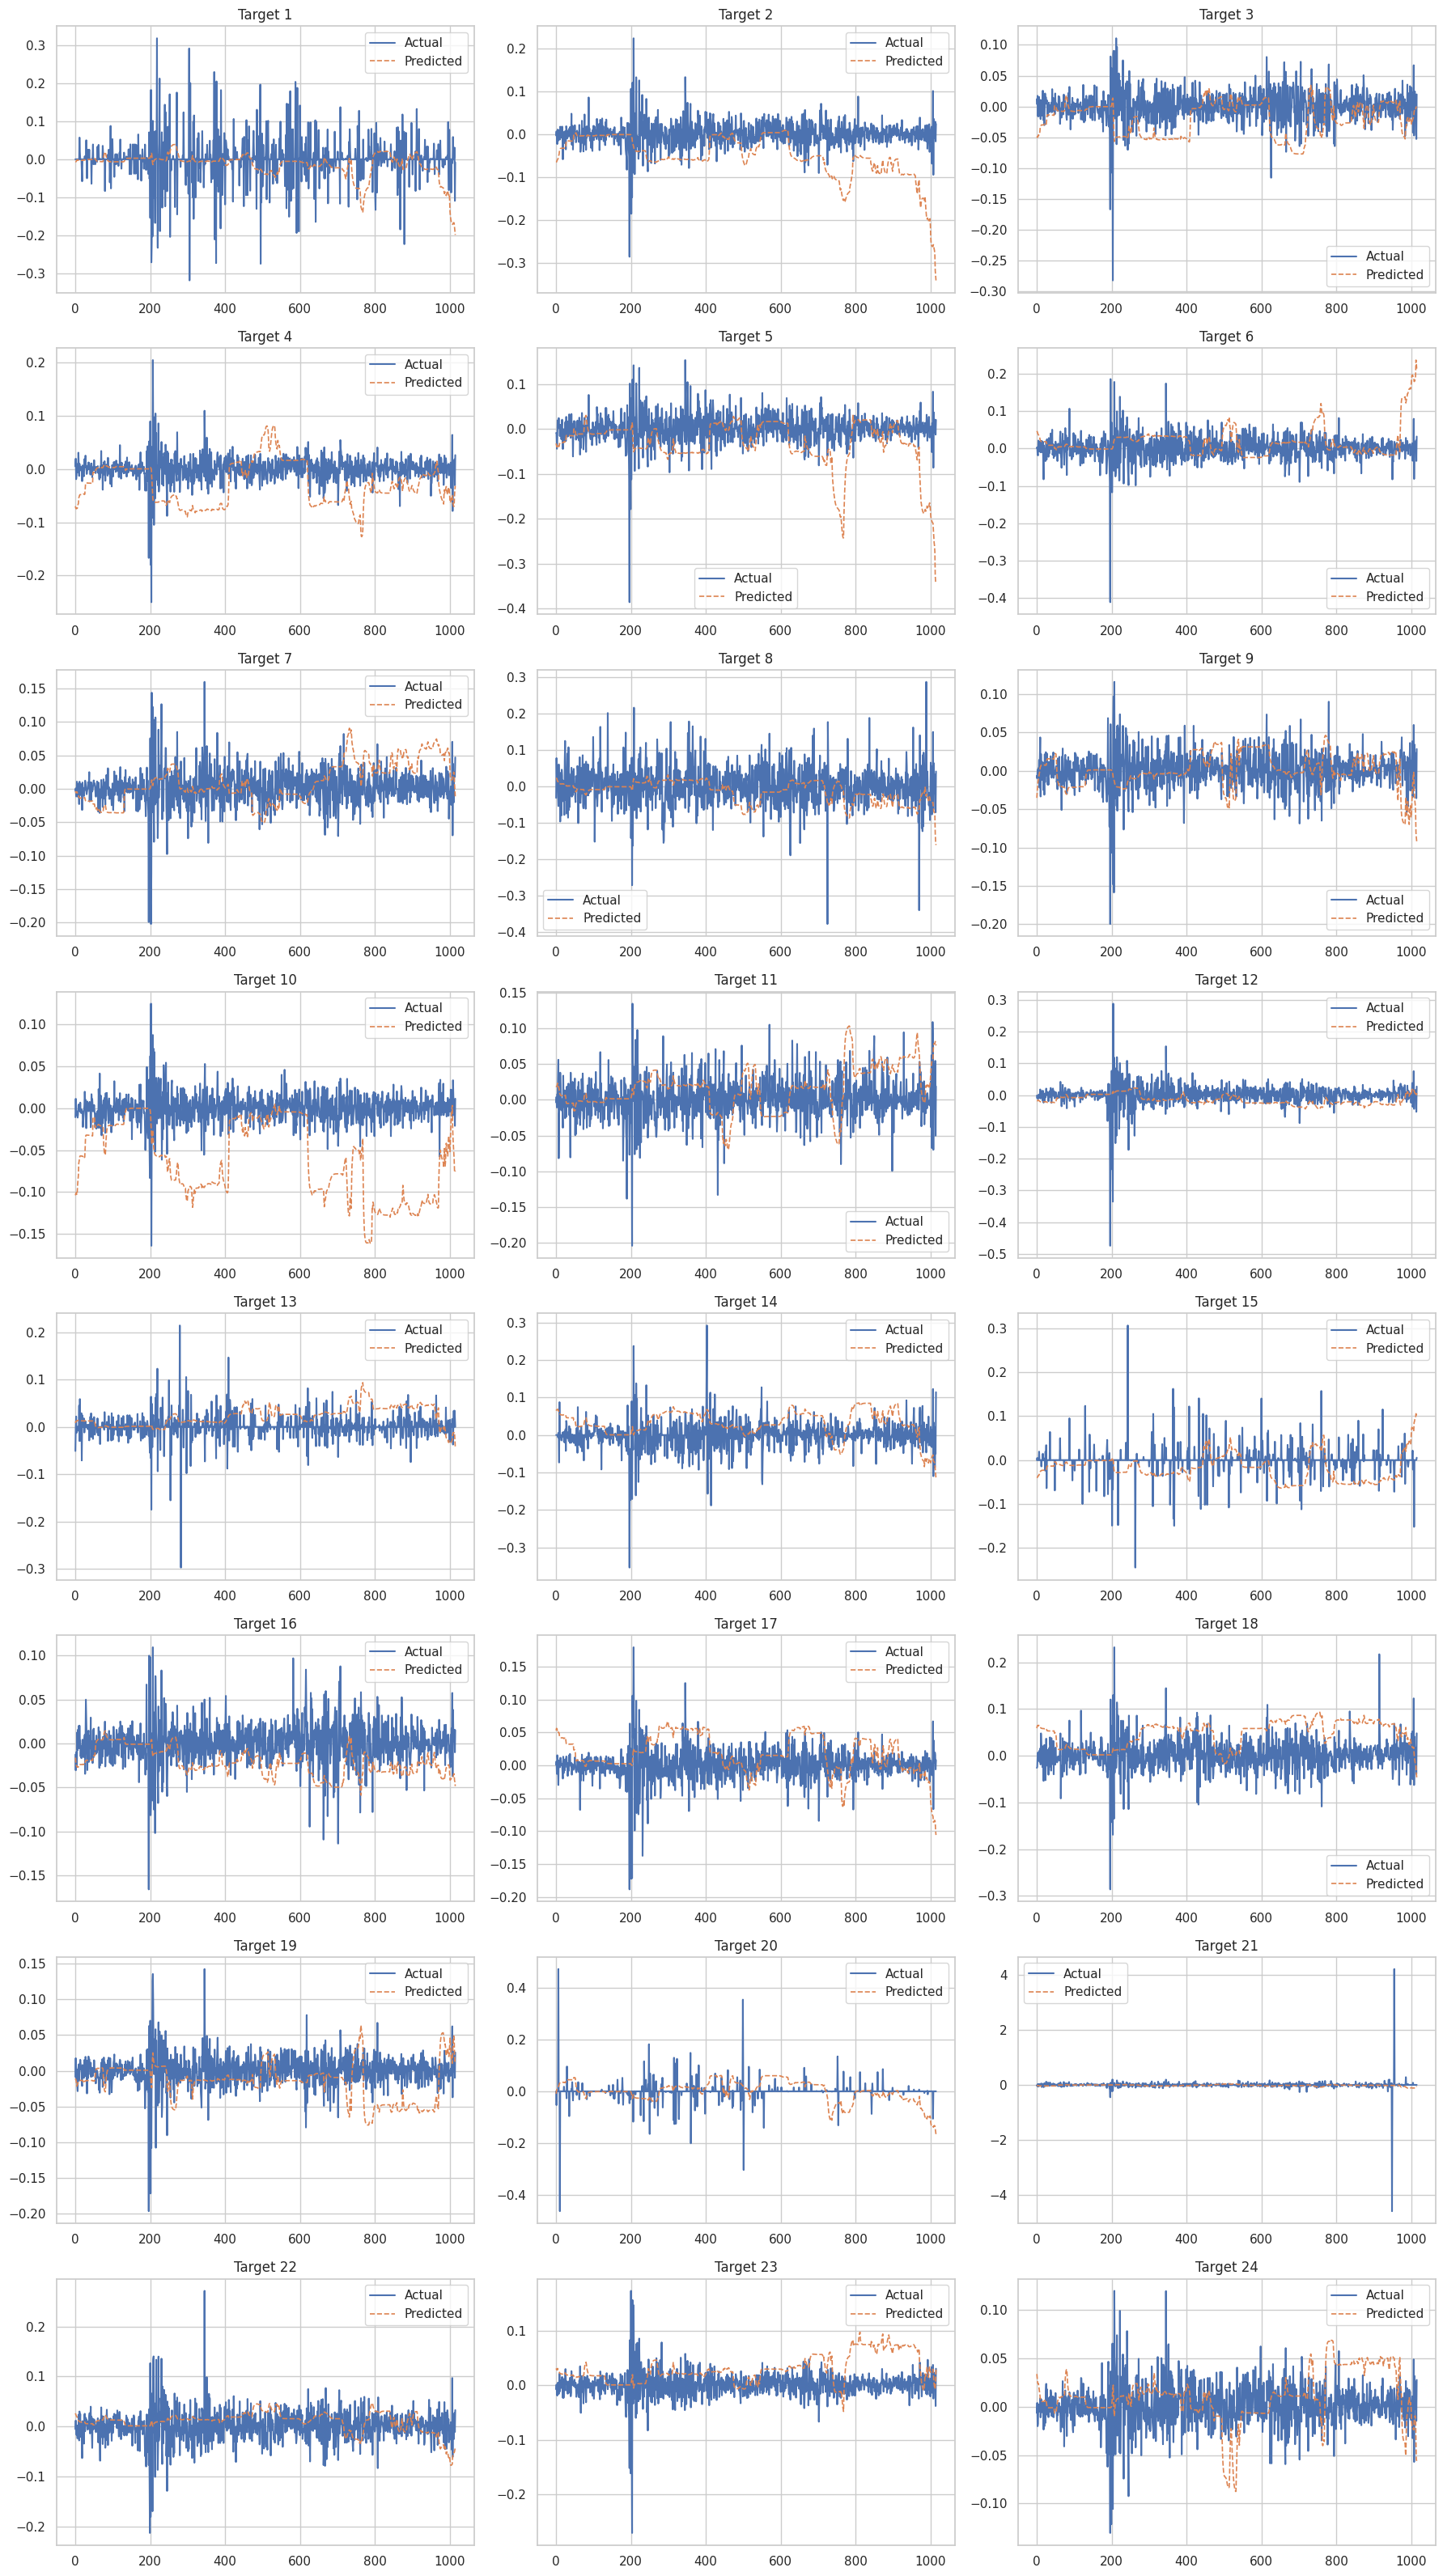

In [ ]:
import matplotlib.pyplot as plt

num_targets = y_test_seq.shape[1]
fig, axs = plt.subplots(nrows=(num_targets + 2) // 3, ncols=3, figsize=(18, 4 * ((num_targets + 2) // 3)))
axs = axs.flatten()  # Flatten in case of multiple rows

for i in range(num_targets):
    axs[i].plot(y_test_seq[:, i], label="Actual", linewidth=1.5)
    axs[i].plot(y_pred[:, i], label="Predicted", linewidth=1.2, linestyle="--")
    axs[i].set_title(f"Target {i + 1}")
    axs[i].legend()
    axs[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [ ]:
print(np.isnan(X_train_seq).sum(), np.isnan(y_train_seq).sum())
print(np.std(y_train_seq, axis=0))  # Should not be ~0

0 0
[0.03926401 0.01763253 0.02054217 0.01368894 0.01922985 0.02268087
 0.01606172 0.07180248 0.02787167 0.01408236 0.03651374 0.01957091
 0.0221432  0.0341814  0.02762692 0.01810002 0.01403011 0.02185164
 0.01499584 0.04637825 0.04639103 0.02048864 0.02785097 0.01196551]


Tunning

In [ ]:
def create_lstm_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])  # predict current target using past `lookback` steps
    return np.array(X_seq), np.array(y_seq)

In [ ]:
param_grid = {
    'lookback': [30, 60, 90, 120, 150, 252],
    'neurons': [32, 64],
    'dropout': [0.2],
    'batch_size': [32],
    'epochs': [50]
}


In [ ]:
import optuna
from optuna.samplers import TPESampler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'lookback': trial.suggest_categorical('lookback', [30, 60, 90, 120, 150, 252]),
        'neurons_layer1': trial.suggest_int('neurons_layer1', 32, 256, step=32),
        'neurons_layer2': trial.suggest_int('neurons_layer2', 32, 256, step=32),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'epochs': trial.suggest_int('epochs', 10, 100, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
    }

    # Create sequences with the selected lookback
    X_train_seq, y_train_seq = create_lstm_sequences(X_train_scaled, y_train_scaled, lookback=params['lookback'])
    X_val_seq, y_val_seq = create_lstm_sequences(X_test_scaled, y_test_scaled, lookback=params['lookback'])

    # Build model
    model = Sequential([
        LSTM(params['neurons_layer1'], return_sequences=True,
             input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(params['dropout_rate']),
        LSTM(params['neurons_layer2'], return_sequences=False),
        Dropout(params['dropout_rate']),
        Dense(y_train_seq.shape[1])  # Multi-output
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )

    # Train model
    history = model.fit(
        X_train_seq, y_train_seq,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=(X_val_seq, y_val_seq),
        verbose=0
    )

    # Get validation loss
    val_loss = history.history['val_loss'][-1]

    return val_loss

# Create study and optimize
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print best results
print("Best trial:")
trial = study.best_trial
print(f"  Value (Validation Loss): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train final model with best parameters
best_params = trial.params
X_train_seq, y_train_seq = create_lstm_sequences(X_train_scaled, y_train_scaled, lookback=best_params['lookback'])
X_test_seq, y_test_seq = create_lstm_sequences(X_test_scaled, y_test_scaled, lookback=best_params['lookback'])

final_model = Sequential([
    LSTM(best_params['neurons_layer1'], return_sequences=True,
         input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(best_params['dropout_rate']),
    LSTM(best_params['neurons_layer2'], return_sequences=False),
    Dropout(best_params['dropout_rate']),
    Dense(y_train_seq.shape[1])
])

final_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='mse',
    metrics=['mae']
)

final_model.fit(
    X_train_seq, y_train_seq,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_data=(X_test_seq, y_test_seq)
)

[I 2025-05-13 11:27:36,436] A new study created in memory with name: no-name-750323bf-2f77-4533-8b86-1a9321568910
[W 2025-05-13 11:27:36,442] Trial 0 failed with parameters: {'lookback': 60, 'neurons_layer1': 32, 'neurons_layer2': 224, 'dropout_rate': 0.4, 'batch_size': 64, 'epochs': 30, 'learning_rate': 2.3102018878452926e-05} because of the following error: NameError("name 'create_lstm_sequences' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-1-dfd4852ad877>", line 19, in objective
    X_train_seq, y_train_seq = create_lstm_sequences(X_train_scaled, y_train_scaled, lookback=params['lookback'])
                               ^^^^^^^^^^^^^^^^^^^^^
NameError: name 'create_lstm_sequences' is not defined
[W 2025-05-13 11:27:36,445] Trial 0 failed with value None.


NameError: name 'create_lstm_sequences' is not defined

In [ ]:
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Assume X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled already exist

# Your sequence creation function
def create_lstm_sequences(X, y, lookback=120):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Objective function for Optuna
def objective(trial):
    # 1. Suggest hyperparameters
    lookback = trial.suggest_categorical('lookback', [30, 60, 90, 120, 150, 252])
    n_units = trial.suggest_int('neurons', 32, 128, step=32)
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 20, 100, step=10)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True)

    # 2. Create sequences with current lookback
    X_train_seq, y_train_seq = create_lstm_sequences(X_train_scaled, y_train_scaled, lookback)
    X_val_seq, y_val_seq = create_lstm_sequences(X_val_scaled, y_val_scaled, lookback)

    # 3. Build LSTM model
    model = Sequential([
        LSTM(n_units, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(dropout_rate),
        LSTM(n_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(y_train_seq.shape[1])
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # 4. Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 5. Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    # 6. Evaluate on validation set
    y_pred = model.predict(X_val_seq)
    rmse = mean_squared_error(y_val_seq, y_pred, squared=False)
    return rmse  # Or use MAE if preferred


------

-----

In [ ]:
# Hyperparameter grid
    param_grid = {
        'estimator__n_estimators': [200],
        'estimator__learning_rate': [0.05],
        'estimator__max_depth': [3],
        'estimator__min_samples_split': [10]
    }

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_

# 2. Feature Engineering
## Technical Indicators:
Moving averages (10d, 50d, 200d)

RSI (14d)

MACD

Bollinger Bands

In [ ]:
def calculate_technical_indicators(prices, window_short=10, window_moderate=50, window_long=200, window_rsi=14):
    features = pd.DataFrame(index=prices.index)

    for ticker in prices.columns:
        # Returns
        #features[f'{ticker}_return_1d'] = prices[ticker].pct_change()
        #features[f'{ticker}_return_5d'] = prices[ticker].pct_change(5)

        # Moving Averages
        features[f'{ticker}_ma_short'] = prices[ticker].rolling(window_short).mean()
        features[f'{ticker}_ma_moderate'] = prices[ticker].rolling(window_moderate).mean()
        features[f'{ticker}_ma_long'] = prices[ticker].rolling(window_long).mean()

        # RSI
        delta = prices[ticker].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window_rsi).mean()
        avg_loss = loss.rolling(window_rsi).mean()
        rs = avg_gain / avg_loss
        features[f'{ticker}_rsi'] = 100 - (100 / (1 + rs))

        # MACD
        ema12 = prices[ticker].ewm(span=12).mean()
        ema26 = prices[ticker].ewm(span=26).mean()
        features['macd'] = ema12 - ema26
        features['macd_signal'] = features['macd'].ewm(span=9).mean()

        # Bollinger Bands
        rolling_mean = prices[ticker].rolling(window=20).mean()
        rolling_std = prices[ticker].rolling(window=20).std()
        features[f'{ticker}_bollinger_upper'] = rolling_mean + (rolling_std * 2)
        features[f'{ticker}_bollinger_lower'] = rolling_mean - (rolling_std * 2)

    return features.dropna()

technical_features = calculate_technical_indicators(Prices)

<ipython-input-41-a0108d0caa41>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{ticker}_ma_long'] = prices[ticker].rolling(window_long).mean()
<ipython-input-41-a0108d0caa41>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{ticker}_rsi'] = 100 - (100 / (1 + rs))
<ipython-input-41-a0108d0caa41>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

Data Preparation

In [ ]:
# Parameters
HORIZON = 5  # Predicting returns over next 5 days
TEST_START = '2021-01-01'  # Out-of-sample period start
TRAIN_END = '2020-12-31'  # Training period end

features = technical_features.copy()
scaler = StandardScaler()
features = pd.DataFrame(
    scaler.fit_transform(features),
    index=features.index,
    columns=features.columns
)

# 1. Prepare Targets - percentage returns over horizon period
def create_targets(prices, horizon):
    """Create multi-period forward returns"""
    returns = prices.pct_change(horizon).shift(-horizon)
    returns = returns.dropna()
    return returns
    #return prices.pct_change(horizon).shift(-horizon)

# Assuming 'prices' is your DataFrame of stock prices
# targets = create_targets(Prices, HORIZON)
targets = np.log(Prices / Prices.shift(1))

# 2. Align features and targets
common_idx = features.index.intersection(targets.index)
features = features.loc[common_idx]
targets = targets.loc[common_idx].dropna()  # Drop rows where target is NaN

# 3. Time-based split (no shuffling!)
X_train = features.loc[:TRAIN_END]
y_train = targets.loc[:TRAIN_END]
X_test = features.loc[TEST_START:]
y_test = targets.loc[TEST_START:]

# 4. Drop remaining NA rows (from technical indicators)
train_mask = X_train.isna().any(axis=1) | y_train.isna().any(axis=1)
X_train = X_train[~train_mask]
y_train = y_train[~train_mask]

test_mask = X_test.isna().any(axis=1) | y_test.isna().any(axis=1)
X_test = X_test[~test_mask]
y_test = y_test[~test_mask]

In [ ]:
y_test

Ticker          AMEN       COP       CQP       CVX       EOG       HES  \
Date                                                                     
2021-01-04 -0.070433 -0.010558 -0.012848  0.003074 -0.000200  0.000189   
2021-01-05  0.000000  0.055782 -0.002013  0.026675  0.078282  0.068437   
2021-01-06 -0.013606  0.039138  0.030623  0.031677  0.020922  0.054886   
2021-01-07  0.078988  0.026983  0.013591  0.004666  0.062652  0.023659   
2021-01-08 -0.085613  0.000000 -0.004141  0.009487  0.004256 -0.014991   
...              ...       ...       ...       ...       ...       ...   
2025-04-15  0.000000 -0.008480  0.004188 -0.005781 -0.001487 -0.005488   
2025-04-16  0.002361  0.007438  0.019698  0.006076  0.016159  0.005800   
2025-04-17  0.030657  0.029887 -0.002462  0.018373  0.020665  0.020806   
2025-04-21 -0.109129 -0.016202 -0.052626 -0.030488 -0.012659 -0.033627   
2025-04-22 -0.008258  0.024929  0.019721  0.026346  0.020052  0.031635   

Ticker           IMO       LEU       LNG       NFG  ...      RSRV       SBR  \
Date                                                ...                       
2021-01-04  0.017193 -0.080547 -0.018834  0.002913  ... -0.019102  0.029332   
2021-01-05  0.083692 -0.006582  0.043514  0.022532  ...  0.000000  0.003092   
2021-01-06  0.028566  0.054166  0.016921  0.043823  ...  0.000000  0.024065   
2021-01-07  0.016029 -0.004029  0.034551  0.000000  ...  0.000000 -0.006046   
2021-01-08 -0.010505 -0.009919 -0.009149 -0.014395  ...  0.000000  0.018030   
...              ...       ...       ...       ...  ...       ...       ...   
2025-04-15 -0.020301 -0.018829  0.023630  0.005784  ...  0.000000  0.012934   
2025-04-16  0.019658  0.023136  0.002201  0.009059  ...  0.000000  0.002001   
2025-04-17  0.024473  0.031873  0.017433  0.002790  ...  0.000000  0.015563   
2025-04-21  0.017892 -0.071321 -0.035669 -0.020991  ...  0.000000 -0.010043   
2025-04-22  0.046990  0.040675  0.028514  0.011446  ...  0.005442  0.015177   

Ticker          SHEL       TPL       TTE      TTYP     VIRDY       VLO  \
Date                                                                     
2021-01-04  0.025012  0.039856  0.011152  0.000000  0.041243 -0.014960   
2021-01-05  0.066566  0.049560  0.025625  0.000000  0.049271  0.028131   
2021-01-06  0.045185 -0.002493  0.046290  0.000000  0.117783  0.022085   
2021-01-07  0.001240 -0.018248  0.014172  0.100805  0.033617  0.018095   
2021-01-08 -0.002482  0.028261 -0.006298  0.000000 -0.008299 -0.033399   
...              ...       ...       ...       ...       ...       ...   
2025-04-15  0.003830  0.013329 -0.001411  0.000000  0.000000 -0.025520   
2025-04-16  0.019715  0.010473  0.020263  0.000000  0.000000 -0.003913   
2025-04-17  0.015651  0.016350  0.010835  0.000000  0.000000  0.026983   
2025-04-21 -0.006014 -0.038998 -0.009798  0.000000  0.000000 -0.011147   
2025-04-22  0.008011  0.048036  0.025581  0.000000  0.000000  0.032719   

Ticker           WMB       XOM  
Date                            
2021-01-04  0.002490  0.006770  
2021-01-05  0.029897  0.047068  
2021-01-06  0.037436  0.025197  
2021-01-07  0.001859  0.007815  
2021-01-08 -0.011205  0.011060  
...              ...       ...  
2025-04-15  0.020363 -0.002809  
2025-04-16 -0.004795  0.010517  
2025-04-17  0.006160  0.025865  
2025-04-21 -0.037898 -0.014793  
2025-04-22  0.030707  0.027617  

[638 rows x 24 columns]


Train Set Performance:
AMEN: MSE=0.000939, R²=0.5284
COP: MSE=0.000214, R²=0.6070
CQP: MSE=0.000209, R²=0.5896
CVX: MSE=0.000129, R²=0.6354
EOG: MSE=0.000251, R²=0.6035
HES: MSE=0.000317, R²=0.5954
IMO: MSE=0.000168, R²=0.6451
LEU: MSE=0.001872, R²=0.5871
LNG: MSE=0.000354, R²=0.5887
NFG: MSE=0.000116, R²=0.5478
NRP: MSE=0.000498, R²=0.5762
OKE: MSE=0.000236, R²=0.7106
PDER: MSE=0.000275, R²=0.5401
PNRG: MSE=0.000604, R²=0.5416
RSRV: MSE=0.000374, R²=0.5324
SBR: MSE=0.000180, R²=0.5274
SHEL: MSE=0.000129, R²=0.6534
TPL: MSE=0.000275, R²=0.6016
TTE: MSE=0.000137, R²=0.6163
TTYP: MSE=0.000799, R²=0.6254
VIRDY: MSE=0.000922, R²=0.5902
VLO: MSE=0.000288, R²=0.5723
WMB: MSE=0.000258, R²=0.6797
XOM: MSE=0.000100, R²=0.6186


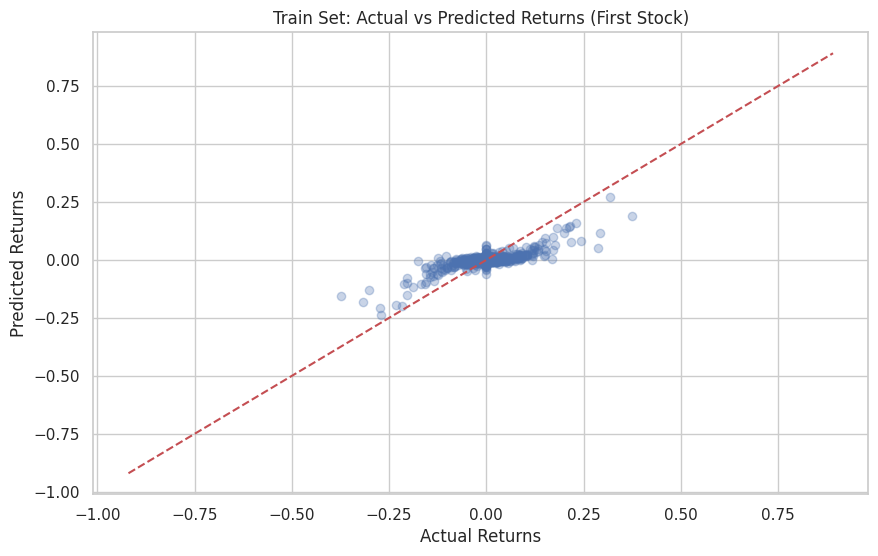


Test Set Performance:
AMEN: MSE=0.010883, R²=-3.7224
COP: MSE=0.002076, R²=-2.9054
CQP: MSE=0.001685, R²=-2.6151
CVX: MSE=0.002358, R²=-7.0127
EOG: MSE=0.001796, R²=-1.8231
HES: MSE=0.003266, R²=-4.2395
IMO: MSE=0.003562, R²=-6.1799
LEU: MSE=0.208556, R²=-74.2344
LNG: MSE=0.000604, R²=-0.4974
NFG: MSE=0.000470, R²=-1.3532
NRP: MSE=0.002073, R²=-1.9339
OKE: MSE=0.001126, R²=-2.0933
PDER: MSE=0.002788, R²=-5.9925
PNRG: MSE=0.002901, R²=-1.3789
RSRV: MSE=0.012317, R²=-16.6928
SBR: MSE=0.000651, R²=-0.2897
SHEL: MSE=0.001223, R²=-2.6033
TPL: MSE=0.002155, R²=-1.2444
TTE: MSE=0.000690, R²=-1.2690
TTYP: MSE=0.038093, R²=-55.4163
VIRDY: MSE=0.094777, R²=-0.4923
VLO: MSE=0.001938, R²=-2.1810
WMB: MSE=0.002230, R²=-8.9651
XOM: MSE=0.000759, R²=-1.1974


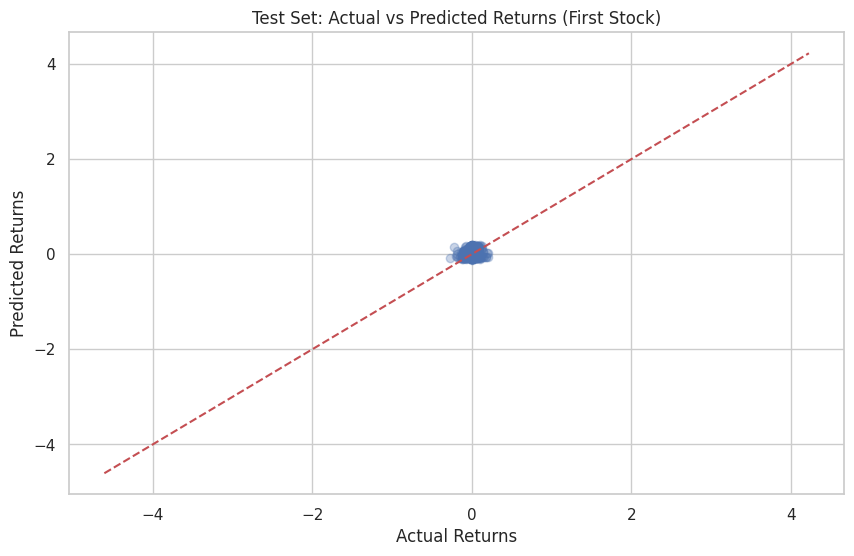

In [ ]:
# 5. Initialize and train model - MultiOutput for all stocks
model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=10,
        random_state=42
    ),
    n_jobs=-1
)

model.fit(X_train, y_train)

# 6. Evaluate
def evaluate_model(model, X, y, set_name="Train"):
    preds = model.predict(X)

    # Calculate returns for each stock
    mse = mean_squared_error(y, preds, multioutput='raw_values')
    r2 = r2_score(y, preds, multioutput='raw_values')

    print(f"\n{set_name} Set Performance:")
    for i, stock in enumerate(y.columns):
        print(f"{stock}: MSE={mse[i]:.6f}, R²={r2[i]:.4f}")

    # Plot actual vs predicted for one stock as example
    plt.figure(figsize=(10, 6))
    plt.scatter(y.iloc[:, 0], preds[:, 0], alpha=0.3)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title(f'{set_name} Set: Actual vs Predicted Returns (First Stock)')
    plt.plot([y.min().min(), y.max().max()],
             [y.min().min(), y.max().max()], 'r--')
    plt.show()

    return preds

train_preds = evaluate_model(model, X_train, y_train, "Train")
test_preds = evaluate_model(model, X_test, y_test, "Test")

In [ ]:
# Parameters
HORIZON = 5  # Predicting returns over next 5 days
TEST_START = '2021-01-01'  # Out-of-sample period start
TRAIN_END = '2020-12-31'  # Training period end

features = technical_features.copy()

# 1. First ensure your target calculation is correct
def create_proper_targets(prices, horizon=5):
    """Calculate future rolling returns properly"""
    # Calculate future returns: (price_t+horizon - price_t)/price_t
    future_prices = Prices.shift(-horizon)
    # Calculate returns: (price_t+horizon - price_t)/price_t
    returns = (future_prices - Prices) / Prices
    return returns

targets = create_proper_targets(Prices, HORIZON)


# 2. Align features and targets BEFORE splitting
common_idx = features.index.intersection(targets.index)
features_aligned = features.loc[common_idx]
targets_aligned = targets.loc[common_idx]

# 3. Drop rows with any NA values (in either features or targets)
valid_mask = ~(features_aligned.isna().any(axis=1)) | ~(targets_aligned.isna().any(axis=1))
features_clean = features_aligned[valid_mask]
targets_clean = targets_aligned[valid_mask]

# 4. Time-based split
split_date = '2021-01-01'
X_train = features_clean.loc[:split_date]
y_train = targets_clean.loc[:split_date]
X_test = features_clean.loc[split_date:]
y_test = targets_clean.loc[split_date:]

# 5. Final validation
print(f"X_train length: {len(X_train)}, y_train length: {len(y_train)}")
print(f"X_test length: {len(X_test)}, y_test length: {len(y_test)}")
print(f"Are lengths equal? {len(X_test) == len(y_test)}")

# Should output:
# X_train length: [some number], y_train length: [same number]
# X_test length: [some number], y_test length: [same number]
# Are lengths equal? True

X_train length: 1833, y_train length: 1833
X_test length: 638, y_test length: 638
Are lengths equal? True



Train Set Performance:
AMEN: MSE=0.001223, R²=0.7510
COP: MSE=0.000382, R²=0.8396
CQP: MSE=0.000430, R²=0.8162
CVX: MSE=0.000232, R²=0.8457
EOG: MSE=0.000563, R²=0.8085
HES: MSE=0.000661, R²=0.8150
IMO: MSE=0.000366, R²=0.8580
LEU: MSE=0.004285, R²=0.8901
LNG: MSE=0.000721, R²=0.8364
NFG: MSE=0.000215, R²=0.8151
NRP: MSE=0.001005, R²=0.8325
OKE: MSE=0.000480, R²=0.8746
PDER: MSE=0.000387, R²=0.7617
PNRG: MSE=0.001046, R²=0.8264
RSRV: MSE=0.000643, R²=0.7808
SBR: MSE=0.000362, R²=0.7871
SHEL: MSE=0.000275, R²=0.8644
TPL: MSE=0.000603, R²=0.8192
TTE: MSE=0.000285, R²=0.8520
TTYP: MSE=0.001390, R²=0.7981
VIRDY: MSE=0.002042, R²=0.8332
VLO: MSE=0.000542, R²=0.8327
WMB: MSE=0.000519, R²=0.8430
XOM: MSE=0.000198, R²=0.8292


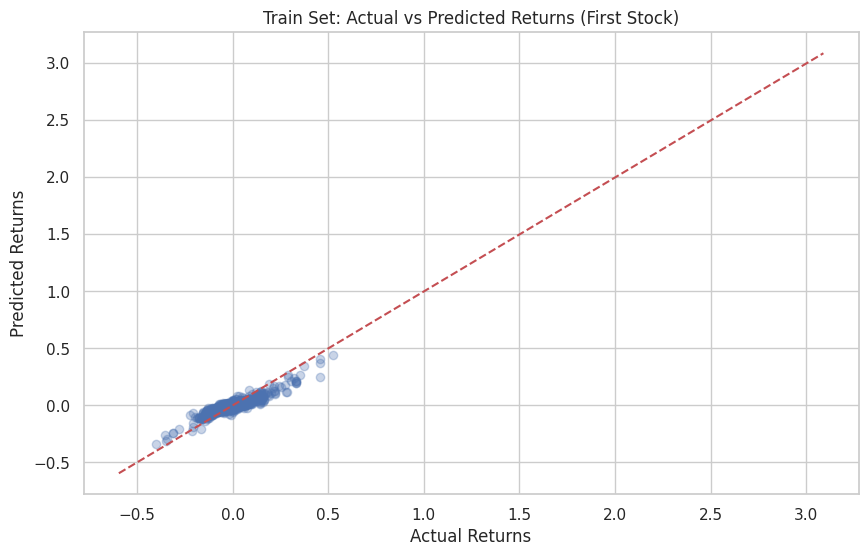

ValueError: Input contains NaN.

In [ ]:
# 5. Initialize and train model - MultiOutput for all stocks
model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=10,
        random_state=42
    ),
    n_jobs=-1
)

model.fit(X_train, y_train)

# 6. Evaluate
def evaluate_model(model, X, y, set_name="Train"):
    preds = model.predict(X)

    # Calculate returns for each stock
    mse = mean_squared_error(y, preds, multioutput='raw_values')
    r2 = r2_score(y, preds, multioutput='raw_values')

    print(f"\n{set_name} Set Performance:")
    for i, stock in enumerate(y.columns):
        print(f"{stock}: MSE={mse[i]:.6f}, R²={r2[i]:.4f}")

    # Plot actual vs predicted for one stock as example
    plt.figure(figsize=(10, 6))
    plt.scatter(y.iloc[:, 0], preds[:, 0], alpha=0.3)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title(f'{set_name} Set: Actual vs Predicted Returns (First Stock)')
    plt.plot([y.min().min(), y.max().max()],
             [y.min().min(), y.max().max()], 'r--')
    plt.show()

    return preds

train_preds = evaluate_model(model, X_train, y_train, "Train")
test_preds = evaluate_model(model, X_test, y_test, "Test")

In [ ]:
# 1. First ensure your target calculation is correct
def create_proper_targets(prices, horizon=5):
    """Calculate future rolling returns properly"""
    # Calculate future returns: (price_t+horizon - price_t)/price_t
    future_prices = prices.shift(-horizon)
    returns = (future_prices - prices) / prices
    return returns

targets = create_proper_targets(Prices, HORIZON)

# 2. Align features and targets BEFORE splitting
common_idx = features.index.intersection(targets.index)
features_aligned = features.loc[common_idx]
targets_aligned = targets.loc[common_idx]

# 3. Drop rows with any NA values (in either features or targets)
valid_mask = ~(features_aligned.isna().any(axis=1)) | ~(targets_aligned.isna().any(axis=1))
features_clean = features_aligned[valid_mask]
targets_clean = targets_aligned[valid_mask]

# 4. Time-based split
split_date = '2021-01-01'
X_train = features_clean.loc[:split_date]
y_train = targets_clean.loc[:split_date]
X_test = features_clean.loc[split_date:]
y_test = targets_clean.loc[split_date:]

# 5. Final validation
print(f"X_train length: {len(X_train)}, y_train length: {len(y_train)}")
print(f"X_test length: {len(X_test)}, y_test length: {len(y_test)}")
print(f"Are lengths equal? {len(X_test) == len(y_test)}")

X_train length: 1833, y_train length: 1833
X_test length: 638, y_test length: 638
Are lengths equal? True


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Parameters
HORIZON = 5  # Predicting returns over next 5 days
TEST_START = '2021-01-01'  # Out-of-sample period start
TRAIN_END = '2020-12-31'  # Training period end

# 1. Create targets properly
def create_proper_targets(prices, horizon):
    """Calculate future percentage returns without lookahead"""
    return prices.pct_change(horizon).shift(-horizon)

targets = create_proper_targets(Prices, HORIZON)

# 2. Align features and targets
common_idx = features.index.intersection(targets.index)
features = features.loc[common_idx]
targets = targets.loc[common_idx]

# 3. Handle missing values - more robust approach
def clean_data(X, y):
    """Remove or impute missing values"""
    # First drop rows where target is NA (these can't be used)
    valid_mask = ~y.isna().any(axis=1)
    X_clean = X[valid_mask]
    y_clean = y[valid_mask]

    # Then handle feature NAs - either impute or drop
    if X_clean.isna().sum().sum() > 0:
        print(f"Imputing {X_clean.isna().sum().sum()} missing values in features")
        imputer = IterativeImputer(random_state=42)
        X_clean = pd.DataFrame(imputer.fit_transform(X_clean),
                              columns=X_clean.columns,
                              index=X_clean.index)
    return X_clean, y_clean

# 4. Time-based split with cleaning
X_train, y_train = clean_data(features.loc[:TRAIN_END], targets.loc[:TRAIN_END])
X_test, y_test = clean_data(features.loc[TEST_START:], targets.loc[TEST_START:])

# Verify no NAs remain
assert not X_train.isna().any().any(), "Training features still contain NAs"
assert not y_train.isna().any().any(), "Training targets still contain NAs"
assert not X_test.isna().any().any(), "Test features still contain NAs"
assert not y_test.isna().any().any(), "Test targets still contain NAs"

# 5. Initialize and train model
model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=10,
        random_state=42
    ),
    n_jobs=-1
)

model.fit(X_train, y_train)

# 6. Evaluation function with NaN checks
def safe_evaluate_model(model, X, y, set_name="Train"):
    """Evaluation with additional data validation"""
    # Final NaN check
    if X.isna().any().any() or y.isna().any().any():
        raise ValueError(f"{set_name} set contains NaN values")

    preds = model.predict(X)

    # Calculate metrics for each stock
    mse = mean_squared_error(y, preds, multioutput='raw_values')
    r2 = r2_score(y, preds, multioutput='raw_values')

    print(f"\n{set_name} Set Performance:")
    for i, stock in enumerate(y.columns):
        print(f"{stock}: MSE={mse[i]:.6f}, R²={r2[i]:.4f}")

    return preds

# 7. Run evaluation
try:
    train_preds = safe_evaluate_model(model, X_train, y_train, "Train")
    test_preds = safe_evaluate_model(model, X_test, y_test, "Test")
except ValueError as e:
    print(f"Evaluation failed: {str(e)}")
    print("Debugging info:")
    print("X_train NA count:", X_train.isna().sum().sum())
    print("y_train NA count:", y_train.isna().sum().sum())
    print("X_test NA count:", X_test.isna().sum().sum())
    print("y_test NA count:", y_test.isna().sum().sum())


Train Set Performance:
AMEN: MSE=0.001215, R²=0.7526
COP: MSE=0.000384, R²=0.8384
CQP: MSE=0.000430, R²=0.8164
CVX: MSE=0.000240, R²=0.8405
EOG: MSE=0.000554, R²=0.8118
HES: MSE=0.000667, R²=0.8135
IMO: MSE=0.000365, R²=0.8581
LEU: MSE=0.004354, R²=0.8884
LNG: MSE=0.000740, R²=0.8321
NFG: MSE=0.000213, R²=0.8163
NRP: MSE=0.001033, R²=0.8277
OKE: MSE=0.000484, R²=0.8735
PDER: MSE=0.000382, R²=0.7650
PNRG: MSE=0.001008, R²=0.8328
RSRV: MSE=0.000642, R²=0.7811
SBR: MSE=0.000362, R²=0.7870
SHEL: MSE=0.000275, R²=0.8643
TPL: MSE=0.000584, R²=0.8248
TTE: MSE=0.000279, R²=0.8548
TTYP: MSE=0.001417, R²=0.7941
VIRDY: MSE=0.001986, R²=0.8377
VLO: MSE=0.000531, R²=0.8360
WMB: MSE=0.000524, R²=0.8418
XOM: MSE=0.000207, R²=0.8217

Test Set Performance:
AMEN: MSE=0.011592, R²=-1.5075
COP: MSE=0.013448, R²=-4.2438
CQP: MSE=0.005815, R²=-1.7323
CVX: MSE=0.016054, R²=-10.0977
EOG: MSE=0.047051, R²=-15.2178
HES: MSE=0.058777, R²=-18.0273
IMO: MSE=0.007125, R²=-1.7527
LEU: MSE=0.033299, R²=-1.9803
LNG: 